# MHC class I genotype vs CH risk

- note: this is the script to reproduce the figures from the report
- more complete analysis is provided in additional scripts 

## Set up

In [1]:
# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
# from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import time 
import csv
import seaborn as sns 
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from myfunctions import transform_format


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:

# specify font size for plotting 
plt.rcParams.update({'font.sans-serif':'Verdana'})

In [3]:

timestr = time.strftime("%Y%m%d") # get current date 

## Import batch data

In [17]:

# path to folder with files (from Hamish)
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'  # Path to ukb files from Hamish 

# Get all files in the folder 
files = glob.glob(os.path.join(folder_path, '*.txt'))  

# Initialize an empty dictionary 
dataframes = {}

# Iterate through the CSV files and read each one with pandas
for csv_file in files:
    
    df = pd.read_csv(csv_file, sep = '\t')
    dataframes[csv_file] = df

# Extract dataframes 
for file_name, df in dataframes.items():
    
    variable_name = file_name.split('/')[8].split('.')[0] + '_data'  # Removing the file extension
    print('Examined file:', variable_name)
    
    df['batch'] = variable_name # add column to indicate source 
    globals()[variable_name] = df  # assign dataframe to the variable 

# Concat all into one df
dfs_to_concat = [v for k, v in globals().items() if k.endswith('_data') and isinstance(v, pd.DataFrame)]

# Row bind all batch dataframes into a single one 
batch_all = pd.concat(dfs_to_concat, ignore_index=True)
batch_all = batch_all.dropna(subset=['batch']) # remove rows which are read incorrectly (w/o batch number)

print('Number of samples called with variants:', batch_all.shape[0])


Examined file: batch_21_annotated_data
Examined file: batch_18_annotated_data
Examined file: batch_15_annotated_data
Examined file: batch_11_annotated_data
Examined file: batch_16_annotated_data
Examined file: batch_12_annotated_data
Examined file: batch_13_annotated_data
Examined file: batch_17_annotated_data
Examined file: batch_14_annotated_data
Examined file: batch_19_annotated_data
Examined file: batch_20_annotated_data
Number of samples called with variants: 76718


In [18]:

# Change numerical variables to integers
batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['position'] = batch_all['position'].astype(int)
batch_all['sample_ID'] = batch_all['sample_ID'].astype(int)

# Subset and create new useful columns
batch_all = batch_all[['sample_ID', 'chromosome', 'end_position', 'VAF', 'var_depth', 'depth', 'Amino_acids', 'SYMBOL', 'Codons', 'batch']]
batch_all['alt_variant'] = batch_all['Amino_acids'].str.split('/', expand = True)[1] # alternative (CH) variant
batch_all['ref_variant'] = batch_all['Amino_acids'].str.split('/', expand = True)[0] # reference variant 

# There are some cases where there is no change in amino acids, for now save as NaN 
batch_all['alt_variant'].fillna(batch_all['Amino_acids'], inplace=True)
batch_all['ref_variant'].fillna(batch_all['Amino_acids'], inplace=True)

# Decided to only use calls with at least two variants based on previous investigation 
batch_all_ns = batch_all[batch_all['var_depth'] >= 2]

# Number of samples with two variant reads or more 
print('Number of samples carrying more than a single read with the variant sequence:', batch_all_ns.shape[0])
batch_all_ns.head(n = 10)


Number of samples carrying more than a single read with the variant sequence: 2823


,sample_ID,chromosome,end_position,VAF,var_depth,depth,Amino_acids,SYMBOL,Codons,batch,alt_variant,ref_variant
41,2100538,chr17,7674894,0.036364,2.0,55.0,R/*,TP53,Cga/Tga,batch_21_annotated_data,*,R
56,2100679,chr2,25234373,0.048780,4.0,82.0,R/H,DNMT3A,cGc/cAc,batch_21_annotated_data,H,R
59,2100706,chr2,25234307,0.019417,2.0,103.0,P/L,DNMT3A,cCg/cTg,batch_21_annotated_data,L,P
64,2100777,chr2,25240313,0.020833,2.0,96.0,R/*,DNMT3A,Cga/Tga,batch_21_annotated_data,*,R
65,2100788,chr2,25240420,0.131148,8.0,61.0,Y/C,DNMT3A,tAc/tGc,batch_21_annotated_data,C,Y
83,2101006,chr2,25240420,0.027778,2.0,72.0,Y/S,DNMT3A,tAc/tCc,batch_21_annotated_data,S,Y
109,2101361,chr17,76736877,0.025641,2.0,78.0,P/H,SRSF2,cCc/cAc,batch_21_annotated_data,H,P
126,2101637,chr2,25240313,0.021739,2.0,92.0,R/*,DNMT3A,Cga/Tga,batch_21_annotated_data,*,R
130,2101708,chr17,7675088,0.033898,2.0,59.0,R/H,TP53,cGc/cAc,batch_21_annotated_data,H,R
154,2102011,chr15,90088702,0.097561,4.0,41.0,R/Q,IDH2,cGg/cAg,batch_21_annotated_data,Q,R


In [19]:

# Import indexes tested in each batch 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls/batch_ids'  # Path to ukb files from Hamish 

# Get all files in the folder 
files_ids = glob.glob(os.path.join(folder_path, '*.tsv'))  

# Read each file one by one 

indexes = {}

# Iterate through the CSV files and read each one with pandas
for file in files_ids:
    
    id = pd.read_csv(file, sep = '\t')
    id = id.rename(columns={'batch ID': 'sample_ID'})
    id['sample_ID'] = id['sample_ID'].str.split('_', n = 1).str[0]
    indexes[file] = id

for file_name, df in indexes.items():
    
    variable_name = file_name.split('/')[9].split('.')[0]    # Remove file extension
    globals()[variable_name] = df  # Assign the DataFrame to a variable with the file name


## Annotate samples with genetic variants carried 

In [20]:

# Find out how many gene_variants were called:

# don't show warnings 
import warnings
warnings.filterwarnings("ignore")

# identify variants called 
batch_all_ns['variant_coord'] = batch_all_ns['chromosome'].astype(str) + "_" + batch_all_ns['end_position'].astype(str) # specific position in the genome 
batch_all_ns['variant_coord'] = batch_all_ns['variant_coord'].astype('category')
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord'].astype(str) +  "_" + batch_all_ns['SYMBOL'].astype(str) + "_" + batch_all_ns['ref_variant'].astype(str) + "_" + batch_all_ns['alt_variant'].astype(str) # change to a specific aa
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord_pos'].astype('category')

# remove samples that have not been annotated (you can tell from the coordinate what is likely but these could be different mutations)
batch_all_ns = batch_all_ns.dropna(subset=['SYMBOL']) # remove column where gene is not known 
print('Number of samples which have been correctly annotated:', batch_all_ns.shape[0]) # but at each site, you are getting reads modified to sth else 
# ok so sth worked wrong with annotation in only 5 cases > that looks good 

# identify the number of variants in a specific position
num_variants = pd.DataFrame(batch_all_ns['variant_coord_pos'].value_counts())
num_variants = num_variants[num_variants['count']!=0]
num_variants = num_variants.sort_values(by = 'count')
num_variants['variant_coord_pos'] = num_variants.index
num_variants = num_variants.reset_index(drop=True)
num_variants = num_variants.sort_values(by = 'variant_coord_pos')
print('Number of variants identified in batches analysed:', num_variants.shape[0]) # but at each site, you are getting reads modiifed to sth else 

# identify the number of positions we looked at
num_sites = pd.DataFrame(batch_all_ns['variant_coord'].value_counts())
num_sites = num_sites[num_sites['count']!=0]
num_sites = num_sites.sort_values(by = 'count')
num_sites['variant_coord'] = num_sites.index
num_sites = num_sites.reset_index(drop=True)
num_sites = num_sites.sort_values(by = 'variant_coord')
print('Number of sites identified in batches analysed:', num_sites.shape[0]) # okay see so you only found 37 sites 

# we have more variants than sites because for each site, we look at any change from the reference sequence (any possible variant)
# at the same time, because we have this data, we can check if we have more variants that "random" mutations


Number of samples which have been correctly annotated: 2818
Number of variants identified in batches analysed: 89
Number of sites identified in batches analysed: 41


In [21]:

# Annotation (using df with variant names and genomic coordinates)

# read in the df with coordinates
coord_gene_var = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ch_variants_coordinates_tp53_added_nts.csv')

# all coordinates identified in the batches  
coord_out = num_sites['variant_coord'].tolist()

# intersection (annotate)
coord_gene_var['variant_coord'] = coord_gene_var['chromosome'] + "_" + coord_gene_var['end_position'].astype(str) # find cariant coordinates
coord_gene_var['SYMBOL'] = coord_gene_var['gene_var'].str.split('_').str[0] # find gene analysed
coord_gene_var['ref_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[0] # reference sequence variant 
coord_gene_var['alt_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[-1] # alternative sequence (CH / mutation) variant
coord_gene_var['variant_coord_pos'] = coord_gene_var['variant_coord'].astype(str) + "_" + coord_gene_var['SYMBOL'].astype(str) + "_" + coord_gene_var['ref_variant'].astype(str) + "_" + coord_gene_var['alt_variant'].astype(str) # specific mutation 

print('Number of variants which have been investigated:', len(coord_gene_var.variant_coord_pos.unique()))
print('Number of sites which have been investigated:',len(coord_gene_var.variant_coord.unique()))

# NOTE: 
# TP53_R249S was searched for but not found in any of the batches so far 
# there have been 5 samples identified (in DNMT3A, at 2 different sites) with variants that I did not originally search for 
# in addition, some of the variants were offset by one base (could have been a deletion / insertion)
# this is why we have differences in the number of sites in the two datasets 


Number of variants which have been investigated: 42
Number of sites which have been investigated: 36


In [22]:

# identify CH variants typed in the dataset 
gene_vars = coord_gene_var[['variant_coord_pos', 'gene_var']]

# subset batch df to only include variants which were successfully identified 
batch_gene_vars = pd.merge(batch_all_ns, gene_vars, on = 'variant_coord_pos', how = 'inner')
batch_gene_vars['gene_var'] = batch_gene_vars['gene_var'].astype('category')
batch_gene_vars['gene_var'].value_counts()
# rename sample ID to person ID column 
batch_gene_vars = batch_gene_vars.rename(columns={'sample_ID': 'Person_ID'})

gene_vars_count = pd.DataFrame(batch_gene_vars['gene_var'].value_counts())
gene_vars_count['gene_var'] = gene_vars_count.index
gene_vars_count = gene_vars_count.reset_index(drop=True)
gene_vars_sorted = gene_vars_count.sort_values(by = 'count', ascending=False)

print('Number of variants identified with annotations:', gene_vars_sorted.shape[0])
# so we will have 30 variants to look at bc the rest was not mapped correctly 

print('Number of samples with a mutation in a CH-relevant position (with >2 reads):', batch_all_ns.shape[0])
print('Number of patients with a mutation in a CH-relevant position (with >2 reads):', len(batch_all_ns.sample_ID.unique()))
print('Number of samples with a CH hotspot mutation (with > 2 reads):', batch_gene_vars.shape[0])
print('Number of patients with a CH hotspot mutation (with > 2 reads):', len(batch_gene_vars.Person_ID.unique()))

Number of variants identified with annotations: 32
Number of samples with a mutation in a CH-relevant position (with >2 reads): 2818
Number of patients with a mutation in a CH-relevant position (with >2 reads): 2761
Number of samples with a CH hotspot mutation (with > 2 reads): 2249
Number of patients with a CH hotspot mutation (with > 2 reads): 2214


## Add age data 

In [23]:

# load the age dataset 
# NOTE: age here is only available for healthy (ie cancer-free), therefore we also exclude cancer patients from analysis 
age_data = pd.read_csv('~/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/2022-05-20_healthy_pheno.tsv', sep = '\t')

age_df = age_data[['ID_v0', 'Age.when.attended.assessment.centre_v0']]
age_df.columns.values[0] = 'Person_ID'
age_df.columns.values[1] = 'age'

print('Number of individuals for whom age data is available:', age_df.shape[0])

Number of individuals for whom age data is available: 459385


In [24]:

# add age data to the rest of the data 

batch_gene_age = pd.merge(batch_gene_vars, age_df, on = 'Person_ID') 
print("Number of sample with available CH variant:", batch_gene_vars.shape[0])
print("Number of sample with available CH variant and age:", batch_gene_age.shape[0])
# note: this is throwing away patients who have been diagnosed with cancer (this dataset is for healthy individuals only)
# I think it is valid and makes sense to not include patients who are diagnosed with cancer 

Number of sample with available CH variant: 2249
Number of sample with available CH variant and age: 1986


# Load MHC class I genotyping data

In [26]:

# add MHC genotype data to CH cases

# path to file
file_hla = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/UKBB/ukb_typed_hla_with_ids_07_threshold_processed.txt"

# get the header 
header = pd.read_csv(file_hla, sep='\t', nrows=1, header=None).values.tolist()
head = [item for sublist in header for item in sublist]

# load the dataframe 
df = pd.read_csv(file_hla, skiprows = 1, sep = ' ', header = None)

# add columns 
df.columns = head 

# subset data for HLA-I and HLA-II class alleles 
# we are only interested in HLA-I for the momnet 
df_hla1 = df.filter(regex='^(Person_|A_|B_|C_)') # 488377 cases 
df_hla2 = df.filter(regex='^(Person_|D)') # 488377 cases 

# clean up the dataset (filtering according to Krishna et al., 2024 Science: remove people in whom not all alleles were genotyped with sufficient confidence)
df_clean_hla1 = df_hla1[~df_hla1.isin([0.5]).any(axis=1)] # exclude people for whom we lacked a genotype
df_clean_hla1 = df_clean_hla1[~df_clean_hla1.isin([1.5]).any(axis=1)] # exclude people for whom we lacked a genotype
df_clean_hla2 = df_hla2[~df_hla2.isin([0.5]).any(axis=1)] # exclude people for whom we lacked a genotype
df_clean_hla2 = df_clean_hla2[~df_clean_hla2.isin([1.5]).any(axis=1)] # exclude people for whom we lacked a genotype

print("Number of samples with imputed HLA:", df_hla1.shape[0])
print("Number of samples with confidently imputed MHC I:", df_clean_hla1.shape[0])
print("Number of samples with confidently imputed MHC II:", df_clean_hla2.shape[0])

# identify people who have correctly genotyped MHC class I and class II 
ids_hla1 = df_clean_hla1.Person_ID.tolist()
ids_hla2 = df_clean_hla2.Person_ID.tolist()
ids_correct_genotype = list(set(ids_hla1).intersection(ids_hla2))
print('Number of UKBB participants with correctly genotyped MHC class I and II:', len(ids_correct_genotype))


Number of samples with imputed HLA: 488377
Number of samples with confidently imputed MHC I: 443620
Number of samples with confidently imputed MHC II: 378317
Number of UKBB participants with correctly genotyped MHC class I and II: 346968


In [27]:

# now you need to merge the data that you want to use with the allele data to get predictions
# most comprehensive dataset we have is batch_gene_age (includes genetic variant someone carries and age)
# Find IDs of CH-affected persons and match to their HLA genotype 

batch_gene_vars.rename(columns={'sample_ID': 'Person_ID'}, inplace=True)
batch_gene_age.rename(columns={'sample_ID': 'Person_ID'}, inplace=True)
ids_batch = batch_gene_age['Person_ID']
hla_batch_ids = df_clean_hla1[df_clean_hla1['Person_ID'].isin(ids_batch)] 

# add HLA genotype data to samples with annotated CH variant and age
batch_gene_age_hla = pd.merge(batch_gene_age, hla_batch_ids, on='Person_ID')
print("Number of samples with available CH variant:", batch_gene_vars.shape[0])
print("Number of samples with available CH variant (healthy):", batch_gene_age.shape[0])
print('Number of samples with annotated variants CH variant and age and HLA genotype:', batch_gene_age_hla.shape[0]) # 1 HLA genotype missing 

# first, filter the df such that we only have MHC alleles for which predictions are available 
hla_ukbb = df_clean_hla1.filter(regex='\d').columns # HLA from all UKBB
print('Number of HLA alleles which have been identified in the UK BioBank:', len(hla_ukbb))


Number of samples with available CH variant: 2249
Number of samples with available CH variant (healthy): 1986
Number of samples with annotated variants CH variant and age and HLA genotype: 1798
Number of HLA alleles which have been identified in the UK BioBank: 214


In [28]:

# Filtering 2: we will only be looking at variants for which we have more than 10 samples 
gene_vars_count = pd.DataFrame(batch_gene_vars['gene_var'].value_counts())
gene_vars_count['gene_var'] = gene_vars_count.index
gene_vars_count = gene_vars_count.reset_index(drop=True)
gene_vars_sorted = gene_vars_count.sort_values(by = 'count', ascending=False)

variants_to_examine = gene_vars_sorted[gene_vars_sorted['count'] >= 15].gene_var.tolist()
print('Number of variants to examine (top 20 most common ones):', len(variants_to_examine))

# filter the dataframe to only include CH variants with minimum 10 samples 
# we will be using this dataset going forward 
batch_gene_vars_hla_10 = batch_gene_age_hla[batch_gene_age_hla['gene_var'].isin(variants_to_examine)]
print('Number of samples with a CH hotspot mutation (with > 2 reads):', batch_gene_vars.shape[0])
print('Number of patients with a CH hotspot mutation (with > 2 reads):', len(batch_gene_vars.Person_ID.unique()))
print('Number of samples with a CH hotspot mutation (with > 2 reads) (common variants):', batch_gene_vars_hla_10.shape[0])
print('Number of patients with a CH hotspot mutation (with > 2 reads) (common variants):', len(batch_gene_vars_hla_10.Person_ID.unique()))

# make sure you only have correct levels of things 
batch_gene_vars_hla_10.gene_var = batch_gene_vars_hla_10.gene_var.astype(str)
batch_gene_vars_hla_10.gene_var = batch_gene_vars_hla_10.gene_var.astype('category')


Number of variants to examine (top 20 most common ones): 20
Number of samples with a CH hotspot mutation (with > 2 reads): 2249
Number of patients with a CH hotspot mutation (with > 2 reads): 2214
Number of samples with a CH hotspot mutation (with > 2 reads) (common variants): 1737
Number of patients with a CH hotspot mutation (with > 2 reads) (common variants): 1710


# Load MHC binding affinity prediction

In [29]:

# need to change format of HLA allele name to align with HLA genotyping file

import re

# transform format (from NetMHCpan data to UKBB format)
def transform_format_netmhc(input_string):
    # a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w\S*)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1).replace('*', '') # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

# transform format (from NetMHCpan data to UKBB format) - VERY annoyingly running the same pipeline I can get different formats of HLA allele names
def transform_format_netmhc_2(input_string):
    # a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1) # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

# transform format (from PRIME format to UKBB format)
def transform_format_prime(input_string):
    # regular expression pattern to match the input format
    # Nb PRIME is almost the same as NetMHC but there is no star after "HLA-A*"
    pattern = re.compile(r'HLA-(\w)(\d{2}):(\d{2})')

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1).replace('*', '') # remove the star 
        group2 = int(match.group(2)) # remove zeros at the start 
        group3 = match.group(3) # leave as it is 

        # Format the output string
        output_string = f'{group1}_{group2}{group3}' # stitch back 
        return output_string # return transformed string 

    # if no much, return original string 
    return input_string

In [30]:

# Import NetMHC scores  

pred_file_net = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/netMHC_out/scores/20240210_NetMHC_HLA_UKBB_with_affinities_bestscores.csv' # EL scores, BA scores, EL rank, BA rank, affinity prediction
pred_filename_net = pred_file_net.split('/')[2].split('.')[0] # identify file name 
pred_method_net = pred_file_net.split('_out')[0] # identify method used to obtain predictions

# load the csv
netmhc = pd.read_csv(pred_file_net) # load the csv 
netmhc = netmhc.rename(columns={'Aff(nM)': 'Aff_nM'})

# specify HLA allele naming format 
NET_col = netmhc.HLA
NET_formatted = NET_col.apply(transform_format_netmhc)
netmhc = pd.concat([netmhc, NET_formatted.rename('HLA_formatted')], axis = 1)

# select required columns and sor values 
netmhc = netmhc[['HLA_formatted', 'Peptide', '%Rank_EL', 'Score_EL', '%Rank_BA', 'Score_BA', 'Aff_nM', 'gene', 'variant', 'genotype']]
netmhc = netmhc.sort_values(by=['HLA_formatted', 'gene', 'variant', 'genotype'])

# identify gene variants 
netmhc['gene_var_gt'] = netmhc['gene'] + '_' + netmhc['variant'] + '_' + netmhc['genotype'] # add complete genotype data
netmhc['gene_var'] = netmhc['gene'] + '_' + netmhc['variant']
netmhc = netmhc.rename(columns={'Aff(nM)': 'Aff_nM'}) # rename affinity column 
scores_netmhc = netmhc[['HLA_formatted', 'Score_EL', '%Rank_EL', 'Score_BA', '%Rank_BA', 'Aff_nM', 'gene_var', 'gene_var_gt']] # select columns of interest

# Print the results 
print('Number of alleles for which predictions are available (NetMHC):', len(netmhc.HLA_formatted.unique()))
print('Number of unique variants (NetMHC):',  len(netmhc.gene_var.unique()))


Number of alleles for which predictions are available (NetMHC): 194
Number of unique variants (NetMHC): 42


# Get predictions

In [31]:

# define the function to find best score for variant carried by someone
def find_best_score_for_variant_carried(row, df, param):

    '''
    this function assigns predictions from a prediction dataset (df)
    based on the specified parameter of interest 
    in this script, I am only considering %Rank_EL
    '''
    
    row_values = pd.to_numeric(row[1:-2], errors='coerce')
    
    # find alleles which are present 
    hla = row.index[1:-2][row_values >= 1] 
    
    # find values corresponding to these alleles 
    vals = df.loc[df['gene_var'] == row['gene_var'], hla].values.flatten() 
    # print(vals)
    # print(type(vals))
    # it can be that nothing was found e.g., bc there were no predictions made for this variant
    if vals.size == 0: 
        value = None
    
    else: 
    
        if param == "Aff_nM":
            value = min(vals) # highest affinity corresponds to lowest value (see plots above)
        elif param == "%Rank_EL":
            value = min(vals) # the best rank is the lowest one (indicates peptide in top x % of binders)
        elif param == "Score_EL":
            value = max(vals) # the best score is the highest one 
        elif param == "%Rank_BA":
            value = min(vals) # the best rank is the lowest one (indicates peptide in top x % of binders)
        elif param == "Score_BA":
            value = max(vals) # the best score is the highest one
        else:
            print('Incorrect parameter provided') 
    
    return value   


In [32]:

# get predictions

# define a function to obtain dataframes with predictions for different scores 
def pred_to_scores(df, param):

    '''
    Allowed parameters are:
    Aff_nM - affinity (raw number)
    Score_BA - binding affinity score
    Score_EL - elution score
    %Rank_BA - %Rank of binding affinity cf a set of random peptides
    %Rank_EL - %Rank of elution cf a set of random peptides
    '''

    # for a given parameter, prepare a dataframe where you store the genetic variant and best score for each HLA allele
    pred_sub = df[['HLA_formatted', 'gene_var_gt', param]]
    pred_sub_wide = pd.pivot(pred_sub, index='gene_var_gt', columns='HLA_formatted', values=param)
    pred_sub_wide = pred_sub_wide.reset_index() # this is to make sure that you have the gene_var column in there too 
    
    # create a list of HLA alleles genotyped in the UKBB for which predictions are available
    hla_intersect = pred_sub_wide.columns[pred_sub_wide.columns.isin(hla_ukbb)] # HLA in the UKBB which I have predictions for 
    hla_intersect_list = hla_intersect.tolist() 

    # subset predictions to only include scores for available 
    pred_sub = pred_sub_wide[hla_intersect_list + pred_sub_wide.columns[pred_sub_wide.columns.str.contains('gene_var')].tolist()]

    # prepare gene variants names to match names in the Patient file 
    pred_sub = pred_sub[pred_sub['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
    pred_sub['gene_var'] = pred_sub['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
    pred_sub['gene_var'] = pred_sub['gene_var'].str.replace('_refseq', '') # remove refseq if present 

    # subset batch_gene_age_hla file 
    ch_hla_sub = batch_gene_age_hla[hla_intersect_list + batch_gene_age_hla.columns[batch_gene_age_hla.columns.str.contains('gene_var')].tolist()]
    ch_hla_sub = pd.concat([batch_gene_age_hla["Person_ID"], ch_hla_sub], axis=1) # add CH cases 
    ch_hla_sub['score'] = ch_hla_sub.apply(find_best_score_for_variant_carried, df=pred_sub, param=param, axis=1) # add score for the parameter
    ch_hla_scores = ch_hla_sub.dropna() # remove NA (incorrectly annotated cases)

    # merge scores with VAF and age
    age_vaf = batch_gene_age_hla[['Person_ID', 'VAF', 'var_depth', 'age', 'gene_var']]
    ch_hla_merge = pd.merge(ch_hla_scores, age_vaf, on = ['Person_ID', 'gene_var'])

    # now add the columns with VAF and age 
    col_to_select = ['Person_ID', 'gene_var', 'score', 'age', 'var_depth', 'VAF'] # subset the data 
    ch_hla_merge_sub = ch_hla_merge[col_to_select]

    return ch_hla_merge_sub


In [33]:

# run the function 
param = '%Rank_EL' # specify parameter of interest 

# get individual dataframes
ch_best_el_rank = pred_to_scores(netmhc, param) # generate dataframe with scores for all CH cases
ch_best_el_rank['score_type'] = '%Rank_EL_NetMHC' # add so you know what score you are using 

# for affinity and ranking, convert to negative log (higher -1log(rank) = tighter binding / more immunogenic)
ch_best_el_rank['log_score'] = -1*np.log10(ch_best_el_rank['score']) # convert score to -log10(score)


# Test 1: Compare scores between carriers and random sample of non-carriers

In [34]:

# define the function to find best scores 

def find_best_score_for_all_variants(row, df, param):

    '''
    Allowed parameters are:
    Aff_nM - affinity (raw number)
    Score_BA - binding affinity score
    Score_EL - elution score
    %Rank_BA - %Rank of binding affinity cf a set of random peptides
    %Rank_EL - %Rank of elution cf a set of random peptides
    '''

    hlas = row.index[1:-1][row[1:-1] >= 1] # select alleles which each Person (row) carries
   
    # it may be that we don't have this column in case we are doing this for non-CH cases
   
    variants = df['gene_var'] # get out variants which are present 
   
    scores = {} # initialise empy dictionaries

    # depending on the parameter, pick the minimum of maximum value 
    if param == "Aff_nM":
        for var in variants:
            # Find the minimum value for each variant in the category that is present
            best_value = min(df.loc[df['gene_var'] == var, hlas].values[0])
            # Update the dictionary with the minimum value for the corresponding variant
            scores[f'score_{var}'] = best_value
        return pd.Series(scores)

    elif param == "Score_BA":
        for var in variants:
            
            best_value = max(df.loc[df['gene_var'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value
        
        return pd.Series(scores)

    elif param == "Score_EL":
        for var in variants:
           
            best_value = max(df.loc[df['gene_var'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "%Rank_BA":
        for var in variants:

            best_value = min(df.loc[df['gene_var'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "%Rank_EL":
        for var in variants:
            
            best_value = min(df.loc[df['gene_var'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)


In [35]:

# define a function to find best scores for all examined CH variants
def pred_to_scores_all_variants(df, param):

    '''
    Allowed parameters are:
    Aff_nM - affinity (raw number)
    Score_BA - binding affinity score
    Score_EL - elution score
    %Rank_BA - %Rank of binding affinity cf a set of random peptides
    %Rank_EL - %Rank of elution cf a set of random peptides

    For df, you can supply the dataframe with predictions either for NetMHC or PRIME
    '''

    # for a given parameter, prepare a dataframe where you store the genetic variant and best score for each HLA allele
    pred_sub = df[['HLA_formatted', 'gene_var_gt', param]]
    pred_sub_wide = pd.pivot(pred_sub, index='gene_var_gt', columns='HLA_formatted', values=param)
    pred_sub_wide = pred_sub_wide.reset_index() # this is to make sure that you have the gene_var column in there too 
    pred_sub_wide.columns = map(transform_format, pred_sub_wide.columns)

    # create a list of HLA alleles genotyped in the UKBB for which predictions are available
    hla_intersect = pred_sub_wide.columns[pred_sub_wide.columns.isin(hla_ukbb)] # HLA in the UKBB which I have predictions for 
    hla_intersect_list = hla_intersect.tolist() 

    # create the prediction dataset 
    pred_sub = pred_sub_wide[hla_intersect_list + pred_sub_wide.columns[pred_sub_wide.columns.str.contains('gene_var')].tolist()]
    ch_hla_sub = batch_gene_age_hla[hla_intersect_list + batch_gene_age_hla.columns[batch_gene_age_hla.columns.str.contains('gene_var')].tolist()]
    ch_hla_sub = pd.concat([batch_gene_age_hla["Person_ID"], ch_hla_sub], axis=1)
    ch_hla_sub = batch_gene_age_hla[hla_intersect_list + batch_gene_age_hla.columns[batch_gene_age_hla.columns.str.contains('gene_var')].tolist()]
    ch_hla_sub = pd.concat([batch_gene_age_hla["Person_ID"], ch_hla_sub], axis=1) # add CH cases 
    
    # prepare gene variants names to match names in the Patient file 
    pred_sub = pred_sub[pred_sub['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
    pred_sub['gene_var'] = pred_sub['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
    pred_sub['gene_var'] = pred_sub['gene_var'].str.replace('_refseq', '') # remove refseq if present 

    # apply the function to find, for each participant, the best score for each examined CH variant 
    ch_scores_all_var = pd.concat([ch_hla_sub, ch_hla_sub.apply(find_best_score_for_all_variants, df=pred_sub, param=param, axis=1)], axis=1)

    # merge scores with VAF and age
    age_vaf = batch_gene_age_hla[['Person_ID', 'VAF', 'var_depth', 'age', 'gene_var']]
    ch_hla_merge = pd.merge(ch_scores_all_var, age_vaf, on = ['Person_ID', 'gene_var'])

    return ch_hla_merge


In [36]:

# run the function 
params = '%Rank_EL' # here we are only interested in %Rank_EL
ch_all_el_rank = pred_to_scores_all_variants(netmhc, param)

# add a column to indicate the name of the scoring system that you used
ch_all_el_rank['score_type'] = '%Rank_EL_NetMHC'


In [37]:

# now let's also get best log_scores 
def find_best_score_all_variants_log(row, df, param):
    
    '''
    The same function but log scores 
    the only allowed parameters are %Rank_EL and %Rank_BA
    we want -1 * log(score) so the highest score if the most "immunogenic" (best binding) one
    '''
    
    hlas = row.index[1:-1][row[1:-1] >= 1] # select alleles which each Person (row) carries

    variants = df['gene_var']
    
    scores = {} # initialise empty dictionaries

    if param == "%Rank_EL":
        for var in variants:

            # take maximum of the negative log score 
            best_value = max(-1 * np.log10(df.loc[df['gene_var'] == var, hlas].values[0]))
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "%Rank_BA":
        for var in variants:

            # take maxium of the negative log score 
            best_value = max(-1 * np.log10(df.loc[df['gene_var'] == var, hlas].values[0]))
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "Aff_nM":
        for var in variants:

            # take maxium of the negative log score (low aff = more immunogenic)
            best_value = max(-1 * np.log10(df.loc[df['gene_var'] == var, hlas].values[0]))
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)


# define a function to find best scores for all examined CH variants
def pred_to_scores_all_variants_log(df, param):

    '''
    Allowed parameters are:
    Aff_nM - affinity (raw number)
    %Rank_BA - %Rank of binding affinity cf a set of random peptides
    %Rank_EL - %Rank of elution cf a set of random peptides
    '''

    # for a given parameter, prepare a dataframe where you store the genetic variant and best score for each HLA allele
    pred_sub = df[['HLA_formatted', 'gene_var_gt', param]]
    pred_sub_wide = pd.pivot(pred_sub, index='gene_var_gt', columns='HLA_formatted', values=param)
    pred_sub_wide = pred_sub_wide.reset_index() # this is to make sure that you have the gene_var column in there too 
    pred_sub_wide.columns = map(transform_format, pred_sub_wide.columns)

    # create a list of HLA alleles genotyped in the UKBB for which predictions are available
    hla_intersect = pred_sub_wide.columns[pred_sub_wide.columns.isin(hla_ukbb)] # HLA in the UKBB which I have predictions for 
    hla_intersect_list = hla_intersect.tolist() 

    # create the prediction dataset 
    pred_sub = pred_sub_wide[hla_intersect_list + pred_sub_wide.columns[pred_sub_wide.columns.str.contains('gene_var')].tolist()]
    ch_hla_sub = batch_gene_age_hla[hla_intersect_list + batch_gene_age_hla.columns[batch_gene_age_hla.columns.str.contains('gene_var')].tolist()]
    ch_hla_sub = pd.concat([batch_gene_age_hla["Person_ID"], ch_hla_sub], axis=1)
    ch_hla_sub = batch_gene_age_hla[hla_intersect_list + batch_gene_age_hla.columns[batch_gene_age_hla.columns.str.contains('gene_var')].tolist()]
    ch_hla_sub = pd.concat([batch_gene_age_hla["Person_ID"], ch_hla_sub], axis=1) # add CH cases 
    
    # prepare gene variants names to match names in the Patient file 
    pred_sub = pred_sub[pred_sub['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
    pred_sub['gene_var'] = pred_sub['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
    pred_sub['gene_var'] = pred_sub['gene_var'].str.replace('_refseq', '') # remove refseq if present 

    # apply the function to find, for each participant, the best score for each examined CH variant 
    ch_scores_all_var = pd.concat([ch_hla_sub, ch_hla_sub.apply(find_best_score_all_variants_log, df=pred_sub, param=param, axis=1)], axis=1)

    # merge scores with VAF and age
    age_vaf = batch_gene_age_hla[['Person_ID', 'VAF', 'var_depth', 'age', 'gene_var']]
    ch_hla_merge = pd.merge(ch_scores_all_var, age_vaf, on = ['Person_ID', 'gene_var'])

    return ch_hla_merge


In [38]:

# run the function 
param = '%Rank_EL' # allowed parameters (scores we are interested in)
ch_all_el_rank_log = pred_to_scores_all_variants_log(netmhc, param)
ch_all_el_rank_log['score_type'] = '%Rank_EL_log_NetMHC'

In [39]:

# melt the dataset 
df_all_names = ['ch_all_el_rank', 'ch_all_el_rank_log']
dict_melted = {}

for name in df_all_names:

    df = globals()[name] 
    key = f'df_melted_{name}'

    score_columns = [col for col in df.columns if col.startswith('score_')]
    score_columns.remove('score_type') # get rid of this column, we don't want that 
    col_to_select = ['Person_ID', 'gene_var'] + score_columns
    df = df[col_to_select]

    df_melted = pd.melt(df, id_vars=['Person_ID', 'gene_var'])
    dict_melted[key] = df_melted

# get individual dataframes
ch_all_el_rank_melted = dict_melted['df_melted_ch_all_el_rank']
ch_all_el_rank_log_melted = dict_melted['df_melted_ch_all_el_rank_log']

# add a column to indicate the name of the scoring system that you used
ch_all_el_rank_melted['score_type'] = '%Rank_EL_NetMHC'
ch_all_el_rank_log_melted['score_type'] = '%Rank_EL_log_NetMHC'

# In this dataset, for everyone you have the variant they carry (gene_var)
# and the score for each possible CH variant (variable)
# to find the score for the variant they have, need to find all cases where gene_var == log_score_gene_var_ch


In [40]:

df_names_melted = ['ch_all_el_rank_melted', 'ch_all_el_rank_log_melted']
dict_melt_add = {}

for name in df_names_melted:

    df = globals()[name] 
    df['is_variant_present'] = df.apply(lambda row: row['gene_var'] in row['variable'], axis=1)

    levels = [True, False] # set order of levels for plotting
    df['is_variant_present'] = pd.Categorical(df['is_variant_present'].astype(bool), categories=levels, ordered=True) # convert to categorical
    df['gene_var'] = df['gene_var'].astype('category') # convert to categorical

    # NOTE: I want to sort by log score for present variants
    df['gene_var'] = df['gene_var'].astype(str) # convert gene_var to string (not category)
    df['variable'] = df['variable'].astype(str)
    df['mean_variant_score'] = df.groupby('variable')['value'].transform('mean')
    df_sort = df.sort_values(by='mean_variant_score', ascending = False)

    key = f'df_melted_{name}'
    dict_melt_add[key] = df_sort

ch_all_el_rank_melted_sort = dict_melt_add['df_melted_ch_all_el_rank_melted']
ch_all_el_rank_log_melted_sort = dict_melt_add['df_melted_ch_all_el_rank_log_melted']

In [41]:
# subset the dataframe to only include individuals who were actually screened for CH
batch_all['batch_number'] = batch_all['batch'].apply(lambda x: [int(num) for num in re.findall(r'\d+', x)])
batch_numbers_examined = set(batch_all['batch_number'].sum()) 
print('Batches that were examined for variants:', batch_numbers_examined)

all_dataframes = [f'batch_{i}_ids' for i in range(11, 61)]
selected_ids = []

# Iterate through all df name 
for df_name in all_dataframes:
    number = int(re.search(r'\d+', df_name).group())
    # check if number matches numbers of batches examined 
    if number in batch_numbers_examined:        
        selected_ids.append(globals()[df_name])

ids_examined = pd.concat(selected_ids, ignore_index=True)
print('Number of samples examined for variants:', ids_examined.shape[0])

ids_examined_list = ids_examined['sample_ID'].tolist()
ids_examined_list = [int(id) for id in ids_examined_list]

Batches that were examined for variants: {11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}
Number of samples examined for variants: 99597


In [42]:

# select a random set of 2000 non-carriers and compare to scores in carriers

# identify UKBB participants who are not diagnosed with CH 
ch_sampleids = batch_gene_vars['Person_ID']
df_clean_hla1_screened = df_clean_hla1[df_clean_hla1['Person_ID'].isin(ids_examined_list)]
ukbb_no_ch = df_clean_hla1_screened[~df_clean_hla1_screened['Person_ID'].isin(ch_sampleids)]
hla_ukbb = ukbb_no_ch.filter(regex='\d').columns # identify HLA alleles carried by non-CH-individuals in the UKBB data

# prepare dataset with predictions (now just from NetMHC)
scores_netmhc_elrank = scores_netmhc[['HLA_formatted', '%Rank_EL', 'gene_var_gt']]
scores_netmhc_elrank_wide = pd.pivot(scores_netmhc_elrank, index='gene_var_gt', columns='HLA_formatted', values='%Rank_EL')

hla_intersect = scores_netmhc_elrank_wide.columns[scores_netmhc_elrank_wide.columns.isin(hla_ukbb)]
hla_intersect_list = hla_intersect.tolist() # select predictions for alleles which are available in NetMHC / PRIME

pred_sub_wide = scores_netmhc_elrank_wide[hla_intersect_list + scores_netmhc_elrank_wide.columns[scores_netmhc_elrank_wide.columns.str.contains('gene_var_gt')].tolist()]

ukbb_no_ch_hla = ukbb_no_ch[hla_intersect]
ukbb_no_ch = pd.concat([ukbb_no_ch['Person_ID'], ukbb_no_ch_hla], axis = 1)
ukbb_no_ch.head()

ids_non_carriers_healthy = ukbb_no_ch.Person_ID.unique().tolist()
print('Number of healthy (non-CH) individuals in the UKBB:', len(ids_non_carriers_healthy))

pred_sub_wide['gene_var_gt'] = pred_sub_wide.index

Number of healthy (non-CH) individuals in the UKBB: 88462


In [43]:

# define new functions in case you want to get predictions for both CH and refseq

def find_best_score_for_all_variants_ref_ch(row, df, param):

    '''
    Allowed parameters are:
    Aff_nM - affinity (raw number)
    Score_BA - binding affinity score
    Score_EL - elution score
    %Rank_BA - %Rank of binding affinity cf a set of random peptides
    %Rank_EL - %Rank of elution cf a set of random peptides
    '''

    hlas = row.index[1:-1][row[1:-1] >= 1] # select alleles which each Person (row) carries
   
    # it may be that we don't have this column in case we are doing this for non-CH cases
   
    variants = df['gene_var_gt'] # get out variants which are present 
   
    scores = {} # initialise empy dictionaries

    # depending on the parameter, pick the minimum of maximum value 
    if param == "Aff_nM":
        for var in variants:
            # Find the minimum value for each variant in the category that is present
            best_value = min(df.loc[df['gene_var_gt'] == var, hlas].values[0])
            # Update the dictionary with the minimum value for the corresponding variant
            scores[f'score_{var}'] = best_value
        return pd.Series(scores)

    elif param == "Score_BA":
        for var in variants:
            
            best_value = max(df.loc[df['gene_var_gt'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value
        
        return pd.Series(scores)

    elif param == "Score_EL":
        for var in variants:
           
            best_value = max(df.loc[df['gene_var_gt'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "%Rank_BA":
        for var in variants:

            best_value = min(df.loc[df['gene_var_gt'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "%Rank_EL":
        for var in variants:
            
            best_value = min(df.loc[df['gene_var_gt'] == var, hlas].values[0])
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)


def find_best_score_all_variants_log_ref_ch(row, df, param):
    
    '''
    The same function but log scores 
    the only allowed parameters are %Rank_EL and %Rank_BA
    we want -1 * log(score) so the highest score if the most "immunogenic" (best binding) one
    '''
    
    hlas = row.index[1:-1][row[1:-1] >= 1] # select alleles which each Person (row) carries

    variants = df['gene_var_gt']
    
    scores = {} # initialise empty dictionaries

    if param == "%Rank_EL":
        for var in variants:

            # take maximum of the negative log score 
            best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == var, hlas].values[0]))
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "%Rank_BA":
        for var in variants:

            # take maxium of the negative log score 
            best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == var, hlas].values[0]))
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)

    elif param == "Aff_nM":
        for var in variants:

            # take maxium of the negative log score (low aff = more immunogenic)
            best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == var, hlas].values[0]))
            scores[f'score_{var}'] = best_value

        return pd.Series(scores)


In [44]:

# select only HLAs for which we have predictions
df_clean_hla1_hla = df_clean_hla1[hla_intersect]
df_clean_hla1_hla_sel = pd.concat([df_clean_hla1['Person_ID'], df_clean_hla1_hla], axis = 1)

### Prepare datasets

In [45]:

# define necessary functions
def get_score(row):
    
    category = row['gene_var']
    return row[f'score_{category}']

def assign_labels(group):

    total_samples = group.shape[0]
    ordered_group = group.sort_values('score', ascending = True)
    # Assign "bottom" to the first half of the entries and "top" to the rest
    ordered_group['label'] = ['bottom half'] * (total_samples // 2) + ['top half'] * (total_samples - (total_samples // 2))
    
    return ordered_group

In [46]:

# assign labels using the function within each category

df_names_to_label = ['ch_all_el_rank_log']
dict_names_to_label = {}

for name in df_names_to_label:

    # get score for each dataframe
    df = globals()[name] 
    df['score'] = df.apply(get_score, axis = 1)

    # find median score for each variant 
    median_score = df.groupby('gene_var')['score'].transform('median')
    df['median_score_for_group'] = median_score

    # first, add an extra column, group ('top half', 'bottom halfs' for each variant)
    df['group_score'] = 'bottom half'  # everyone gets the low score

    # Note: TOP people will have a HIGHER score than median because we have done negative log transform 
    df.loc[df['score'] >= median_score, 'group_score'] = 'top half'  # top 50% presenters if index is higher than median 

    # make sure ordering is correct
    df['gene_var'] = df['gene_var'].astype('category') 

    # add labels
    df = df.groupby('gene_var', group_keys=False).apply(assign_labels)

    # add the df to the dictionary 
    key = f'df_labels_{name}'
    dict_names_to_label[key] = df

ch_all_el_rank_log_labels = dict_names_to_label['df_labels_ch_all_el_rank_log']

In [47]:

# new way of doing this where you do not sample 5x but you only sample ONE reference from EVERYONE who does not have this variant (CH with different variant or healthy)
# we use 2k for the reference to have a really good idea of how the distribution looks like 
# we also do the plot for all variants together 

# full script to look across variants  

np.random.seed(1) # ensure this is all reproducible 

# specify list of variants to look at 
variants = batch_gene_vars.gene_var.unique()
colors = ['#f00071', '#0422ed']
cols_ch = ['Person_ID', 'gene_var', 'score']

# initialize empty dataframe to store results in 
df_compare_to_ref = pd.DataFrame()

for var in variants:

    var_name = var.replace('_', ' ')
    
    # we will compare to %Rank EL (log) derived from NetMHC now
    ch_scores = ch_all_el_rank_log[ch_all_el_rank_log['gene_var'] == var]
    ch_scores = ch_scores[cols_ch]

    # identify number of variant carriers 
    n =  ch_scores.shape[0]

    if n > 10: # we have filtered the dataset before so all variants should fulfill this condition 

        # find all the dataset that you can sample from
        ids_non_carriers_ch = ch_all_el_rank_log[ch_all_el_rank_log['gene_var'] != var].Person_ID.unique().tolist()
        ids_non_carriers = ids_non_carriers_healthy + ids_non_carriers_ch
        ukbb_not_carrier = df_clean_hla1_hla_sel[df_clean_hla1_hla_sel.Person_ID.isin(ids_non_carriers)]
        ref = ukbb_not_carrier.sample(n=2000, replace=False) # no duplicates
            
        # specify parameter 
        param = '%Rank_EL'

        # add scores 
        ref_scores = pd.concat([ref, ref.apply(find_best_score_all_variants_log_ref_ch, df=pred_sub_wide, param=param, axis=1)], axis=1)
        ref_scores['gene_var'] = 'reference set'
        ref_scores.rename(columns={f'score_{var}_ch': 'score'}, inplace=True)
        ref_scores_var = ref_scores[cols_ch]
        
        # concatenate all dataframes
        scores_compare_all = pd.concat([ch_scores, ref_scores_var], axis=0)
        scores_compare_all["CH_variant_carrier"] = scores_compare_all['gene_var'] == var 
        scores_compare_all["CH_variant_carrier"] = scores_compare_all["CH_variant_carrier"].map({True: 'Carrier', False: 'Non-carrier'})
        
        # add rows to dataframe with data for all variants
        df_compare_to_ref = pd.concat([df_compare_to_ref, scores_compare_all], axis = 0)

In [36]:
# add mutation type 
def add_mut_type(string):
    if string[-1] == '*':
        return 'stop codon'
    else:
        return 'substitution'

In [37]:

# okay we need to add a colum with the variant for everyone (because you have reference sets to a variant but the gene_var column does not say which variant this is reference for)
labels = []
current_label = None

# Iterate through the DataFrame
for idx, row in df_compare_to_ref.iterrows():
    # If the category is 'ch', update the current label
    if row['CH_variant_carrier'] == 'Carrier':
        current_label = row['gene_var']
    # Append the current label to the list
    labels.append(current_label)

# Add the labels list as a new column to the DataFrame
df_compare_to_ref['CH variant'] = labels

# Add column based on the last character of strings in the 'var' column
df_compare_to_ref['mutation_type'] = df_compare_to_ref['CH variant'].apply(add_mut_type)

In [38]:

# figure out desired order of variants on the plot 
ch_all_el_rank_log_melted_sort['median_score'] = ch_all_el_rank_log_melted_sort[ch_all_el_rank_log_melted_sort['is_variant_present']==True].groupby('gene_var')['value'].transform('median')
ch_all_el_rank_log_melted_sort_sort = ch_all_el_rank_log_melted_sort.sort_values(by='median_score', ascending = False)

# change names on the x axis for plotting 
df_compare_to_ref['CH variant2'] = df_compare_to_ref['CH variant'].str.replace('_', '\n')
df_compare_to_ref['gene_var2'] = df_compare_to_ref['gene_var'].str.replace('_', '\n')
ch_all_el_rank_log_melted_sort_sort['gene_var2'] = ch_all_el_rank_log_melted_sort_sort['gene_var'].str.replace('_', '\n')
order = ch_all_el_rank_log_melted_sort_sort.gene_var2.unique()
variants_examined = df_compare_to_ref['CH variant2'].unique().tolist()
order_2 = [var for var in order if var in variants_examined]


In [39]:
# maybe add the number of observations (ie carriers) to the gene (n = )
# however am wondering if this is going to be misleading given that the number of non-carriers is 2000
df_carriers_counts = df_compare_to_ref[df_compare_to_ref['CH_variant_carrier']=='Carrier']['CH variant'].value_counts().reset_index()
df_carriers_counts.columns.values[1] = 'nr_carriers'

df_compare_to_ref2 = pd.merge(df_compare_to_ref, df_carriers_counts, on = 'CH variant')
df_compare_to_ref2['nr_carriers'] = df_compare_to_ref2['nr_carriers'].astype(str)
df_compare_to_ref2['CH variant3'] = df_compare_to_ref2['CH variant2'] + '\n(n=' + df_compare_to_ref2['nr_carriers'] + ')'
df_compare_to_ref2

,Person_ID,gene_var,score,CH_variant_carrier,CH variant,mutation_type,CH variant2,gene_var2,nr_carriers,CH variant3
0,2100679,DNMT3A_R882H,0.189096,Carrier,DNMT3A_R882H,substitution,DNMT3A\nR882H,DNMT3A\nR882H,336,DNMT3A\nR882H\n(n=336)
1,2110983,DNMT3A_R882H,0.970616,Carrier,DNMT3A_R882H,substitution,DNMT3A\nR882H,DNMT3A\nR882H,336,DNMT3A\nR882H\n(n=336)
2,2113574,DNMT3A_R882H,0.835647,Carrier,DNMT3A_R882H,substitution,DNMT3A\nR882H,DNMT3A\nR882H,336,DNMT3A\nR882H\n(n=336)
3,2116112,DNMT3A_R882H,0.970616,Carrier,DNMT3A_R882H,substitution,DNMT3A\nR882H,DNMT3A\nR882H,336,DNMT3A\nR882H\n(n=336)
4,2118726,DNMT3A_R882H,0.759451,Carrier,DNMT3A_R882H,substitution,DNMT3A\nR882H,DNMT3A\nR882H,336,DNMT3A\nR882H\n(n=336)
...,...,...,...,...,...,...,...,...,...,...
41732,1546550,reference set,1.008774,Non-carrier,SF3B1_K666N,substitution,SF3B1\nK666N,reference set,14,SF3B1\nK666N\n(n=14)
41733,1288100,reference set,1.008774,Non-carrier,SF3B1_K666N,substitution,SF3B1\nK666N,reference set,14,SF3B1\nK666N\n(n=14)
41734,1410949,reference set,0.910095,Non-carrier,SF3B1_K666N,substitution,SF3B1\nK666N,reference set,14,SF3B1\nK666N\n(n=14)
41735,2040272,reference set,1.008774,Non-carrier,SF3B1_K666N,substitution,SF3B1\nK666N,reference set,14,SF3B1\nK666N\n(n=14)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/20240329/20240329_method_UKBB_%Rank_EL_for_all_compare_to_ref_set_2k_jitter.pdf'

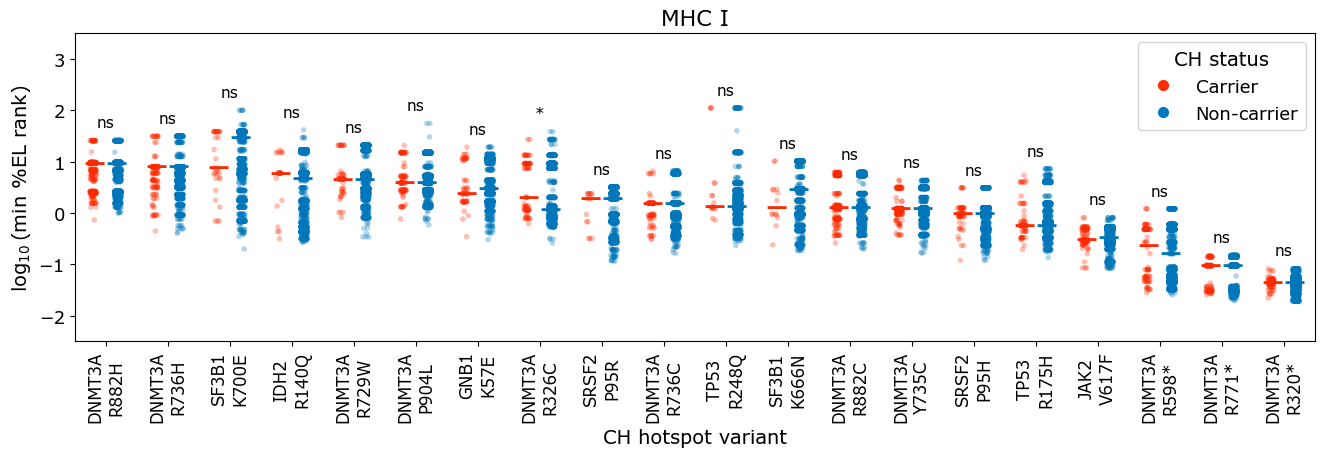

In [40]:

# plot for all variants together 

# jitterplot 
# facet by mutation type 

red0 = '#FC2A00'
blue0 = '#0077bb'
colors = [red0, blue0]

plt.figure(figsize=(16,4)) # set figure size

sns.stripplot(y=f'score', x='CH variant2', hue = 'CH_variant_carrier', data=df_compare_to_ref, dodge = True, jitter = True, palette = colors, size = 4, alpha = 0.3, legend = True, order = order_2)

plt.xlabel(f'CH hotspot variant', fontsize = 14)
plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 14)
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 13)
plt.title('MHC I', fontsize = 16)
plt.ylim(-2.5, 3.5)

# add annotation to indicate median

for i, category in enumerate(order_2):
            
    median_carrier = df_compare_to_ref[(df_compare_to_ref['CH variant2'] == f'{category}') & (df_compare_to_ref['CH_variant_carrier'] == 'Carrier')].score.median()
    median_noncarrier = df_compare_to_ref[(df_compare_to_ref['CH variant2'] == f'{category}') & (df_compare_to_ref['CH_variant_carrier'] == 'Non-carrier')].score.median()

    # Plot text for each hue group
    plt.text(i, median_carrier, '—', ha='right', va='center', fontsize=16, fontweight='bold', color = '#FC2A00')
    plt.text(i, median_noncarrier, '—', ha='left', va='center', fontsize=16, fontweight='bold', color = '#0077bb')

# add kruskall wallis test between groups 
for i, category in enumerate(order_2):
    
    category_data = df_compare_to_ref[df_compare_to_ref['CH variant2'] == f'{category}']
    max_value = category_data['score'].max()

    scores_carrier = df_compare_to_ref[(df_compare_to_ref['CH variant2'] == f'{category}') & (df_compare_to_ref['CH_variant_carrier'] == 'Carrier')].score.tolist()
    scores_noncarrier = df_compare_to_ref[(df_compare_to_ref['CH variant2'] == f'{category}') & (df_compare_to_ref['CH_variant_carrier'] == 'Non-carrier')].score.tolist()

    statistic, p_value = mannwhitneyu(scores_carrier, scores_noncarrier)
    # adjust to the number of tests performed 
    significance = ''
    if p_value > (0.05 / len(variants_examined)):
        significance = 'ns'
    elif p_value < (0.01 / len(variants_examined)):
        significance = '**'
    else:
        significance = '*'
    plt.text(i, 0.2+max_value, significance, ha='center', va='bottom', fontsize=11)

plt.legend(title = 'CH status', markerscale = 2, loc = 'upper right', fontsize = 13, title_fontsize = 14)
legend = plt.gca().get_legend()
for lh in legend.legendHandles:
    lh.set_alpha(1)

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_method_UKBB_{param}_for_all_compare_to_ref_set_2k_jitter.pdf', bbox_inches='tight')


In [ ]:
# change names on the x axis for plotting 
order = [var for var in order if var in variants_examined]
order_3 = df_compare_to_ref2['CH variant3'].unique().tolist()

ch_all_el_rank_log_melted_sort['gene_var2'] = ch_all_el_rank_log_melted_sort['gene_var'].str.replace('_', '\n')
median_scores_df = ch_all_el_rank_log_melted_sort[ch_all_el_rank_log_melted_sort['is_variant_present']==True][['gene_var2', 'median_score']]
median_scores_df.columns.values[0] = 'CH variant2'
df_compare_to_ref2_merged = pd.merge(df_compare_to_ref2, median_scores_df, on = 'CH variant2')

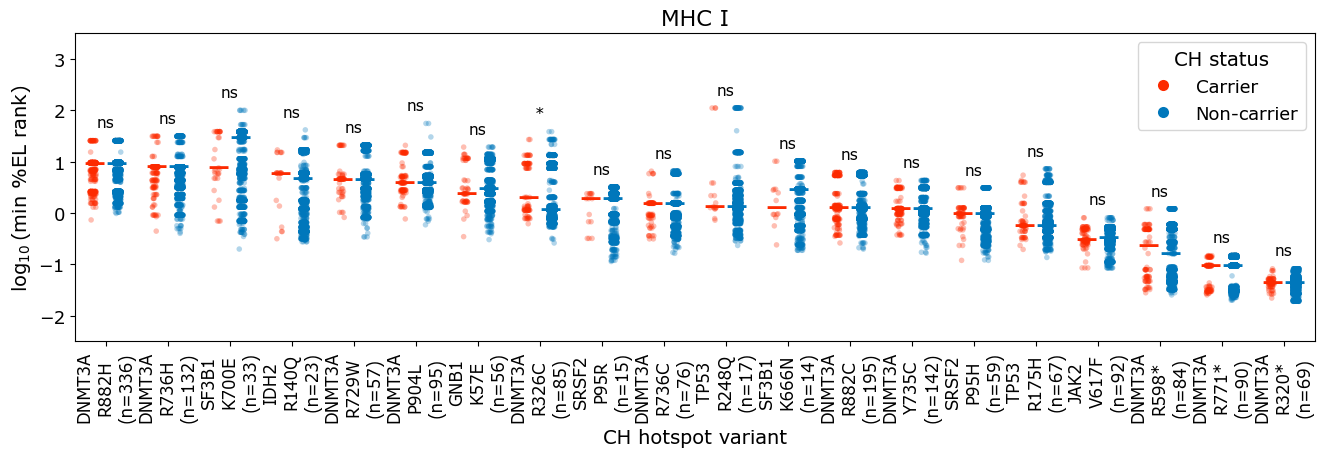

In [ ]:

# plot for all variants together 

# jitterplot 
# facet by mutation type 

# specify order to plot 
order_3 = df_compare_to_ref2_merged.sort_values(by = 'median_score', ascending = False)['CH variant3'].unique().tolist()

# specify colors 
red0 = '#FC2A00'
blue0 = '#0077bb'
colors = [red0, blue0]

plt.figure(figsize=(16,4)) # set figure size

sns.stripplot(y=f'score', x='CH variant3', hue = 'CH_variant_carrier', data=df_compare_to_ref2, dodge = True, jitter = True, palette = colors, size = 4, alpha = 0.3, legend = True, order = order_3)

plt.xlabel(f'CH hotspot variant', fontsize = 14)
plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 14)
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 13)
plt.title('MHC I', fontsize = 16)
plt.ylim(-2.5, 3.5)

# add annotation to indicate median

for i, category in enumerate(order_3):
            
    median_carrier = df_compare_to_ref2[(df_compare_to_ref2['CH variant3'] == f'{category}') & (df_compare_to_ref2['CH_variant_carrier'] == 'Carrier')].score.median()
    median_noncarrier = df_compare_to_ref2[(df_compare_to_ref2['CH variant3'] == f'{category}') & (df_compare_to_ref2['CH_variant_carrier'] == 'Non-carrier')].score.median()

    # Plot text for each hue group
    plt.text(i, median_carrier, '—', ha='right', va='center', fontsize=16, fontweight='bold', color = '#FC2A00')
    plt.text(i, median_noncarrier, '—', ha='left', va='center', fontsize=16, fontweight='bold', color = '#0077bb')

# add kruskall wallis test between groups 
for i, category in enumerate(order_3):
    
    category_data = df_compare_to_ref2[df_compare_to_ref2['CH variant3'] == f'{category}']
    max_value = category_data['score'].max()

    scores_carrier = df_compare_to_ref2[(df_compare_to_ref2['CH variant3'] == f'{category}') & (df_compare_to_ref2['CH_variant_carrier'] == 'Carrier')].score.tolist()
    scores_noncarrier = df_compare_to_ref2[(df_compare_to_ref2['CH variant3'] == f'{category}') & (df_compare_to_ref2['CH_variant_carrier'] == 'Non-carrier')].score.tolist()

    statistic, p_value = mannwhitneyu(scores_carrier, scores_noncarrier)
    # adjust to the number of tests performed 
    significance = ''
    if p_value > (0.05 / len(variants_examined)):
        significance = 'ns'
    elif p_value < (0.01 / len(variants_examined)):
        significance = '**'
    else:
        significance = '*'
    plt.text(i, 0.2+max_value, significance, ha='center', va='bottom', fontsize=11)

plt.legend(title = 'CH status', markerscale = 2, loc = 'upper right', fontsize = 13, title_fontsize = 14)
legend = plt.gca().get_legend()
for lh in legend.legendHandles:
    lh.set_alpha(1)

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_method_UKBB_{param}_for_all_compare_to_ref_set_2k_jitter_with_nr.pdf', bbox_inches='tight')

# Test 2: compare clone sizes (VAFs) depending on MHC presentation

In [ ]:

# Okay, first, we need to get a score column so that will be a log score which matches the gene var someone has 
def get_score(row):
    
    category = row['gene_var']
    return row[f'score_{category}']

# split into a desired number of groups
def split_into_equal_groups(df, num_groups):

    # first, assign a rank to everyone based on score
    # the highest score = the lowest rank (ie highest score means you get rank 1)
    # if two people have the same score, assign consecutive ranks 
    df['rank'] = df['score'].rank(method='first', ascending=False)
    
    # assign groups based on rank 

    # first, determine the number of samples
    total_samples = len(df)

    # now, determine the number of samples in each group
    samples_per_group = total_samples // num_groups
    remainder = total_samples % num_groups
    group_sizes = [samples_per_group + 1 if i < remainder else samples_per_group for i in range(num_groups)] # add one person if there is a reminder 
    
    # now, assign the group based on the rank 
    df_sort = df.sort_values(by = 'rank')
    group_assignments = []
    group_number = 1
    start = 0
    for size in group_sizes:
        end = start + size
        group_assignments.extend([group_number] * (end - start))
        start = end
        group_number += 1

    # Add a new column 'group' to the DataFrame indicating the group assignment for each row
    df_sort['group'] = group_assignments
    
    return df_sort

In [ ]:

# define function to determine if a given case presents the variant well (top 50%)
def presents_variant(row, param):
    scores = {}
    if row[param] == 'top half': # indicates strong binding
       scores[f'presents_variant_{param}'] = True
    elif row[param] == 'top':
        scores[f'presents_variant_{param}'] = True
    else:
        scores[f'presents_variant_{param}'] = False
    return pd.Series(scores)

In [ ]:

# define function to plot
def plot_ranks(data, x, y, hue, colors, order, plt_type, nr, hue_order = None):

    score = data.score_type[0]

    plt.figure(figsize = (16, 4))

    if hue_order is None:
        if plt_type == 'box':
            p = sns.boxplot(x=x, y=y, hue=hue, data=data, showfliers=False, palette=colors, order=order)
            plt.xlabel(f'CH hotspot variant', fontsize = 14)
            plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 14)
            plt.xticks(fontsize = 12, rotation = 90)
            plt.yticks(fontsize = 13)
            plt.title('MHC I', fontsize = 16)
            plt.ylim(-2.5, 3.5)
            plt.legend(title = 'Variant presentation', loc = 'upper right', fontsize = 13, title_fontsize = 14)
            plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_UKBB_dist_{hue}_{y}_{plt_type}_{score}_{nr}.pdf', bbox_inches='tight')

        if plt_type == 'jitter':
            p = sns.stripplot(x=x, y=y, hue=hue, data=data, palette=colors, order=order, size = 5, alpha = 0.3)
            plt.xlabel(f'CH hotspot variant', fontsize = 14)
            plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 14)
            plt.xticks(fontsize = 12, rotation = 90)
            plt.yticks(fontsize = 13)
            plt.title('MHC I', fontsize = 16)
            plt.ylim(-2.5, 3.5)
            plt.legend(title = 'Variant presentation', markerscale = 2, loc = 'upper right', fontsize = 13, title_fontsize = 14)
            legend = plt.gca().get_legend()
            for handle, color in zip(legend.legendHandles, colors):
                handle.set_color(color)
            for lh in legend.legendHandles:
                lh.set_alpha(1)
            plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_UKBB_dist_{hue}_{y}_{plt_type}_{score}_{nr}.pdf', bbox_inches='tight')

    else:
        if plt_type == 'box':
            p = sns.boxplot(x=x, y=y, hue=hue, data=data, showfliers=False, palette=colors, order=order, hue_order=hue_order)
            plt.xlabel(f'CH hotspot variant', fontsize = 14)
            plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 14)
            plt.xticks(fontsize = 12, rotation = 90)
            plt.yticks(fontsize = 13)
            plt.title('MHC I', fontsize = 16)
            plt.ylim(-2.5, 3.5)
            plt.legend(title = 'Variant presentation', loc = 'upper right', fontsize = 13, title_fontsize = 14)
            plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_UKBB_dist_{hue}_{y}_{plt_type}_{score}_{nr}.pdf', bbox_inches='tight')

        if plt_type == 'jitter':
            p = sns.stripplot(x=x, y=y, hue=hue, data=data, palette=colors, order=order, hue_order=hue_order, size = 5, alpha = 0.3)
            plt.xlabel(f'CH hotspot variant', fontsize = 14)
            plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 14)
            plt.xticks(fontsize = 12, rotation = 90)
            plt.yticks(fontsize = 13)
            plt.title('MHC I', fontsize = 16)
            plt.ylim(-2.5, 3.5)
            plt.legend(title = 'Variant presentation', loc = 'upper right', markerscale = 2, fontsize = 13, title_fontsize = 14)
            legend = plt.gca().get_legend()
            for handle, color in zip(legend.legendHandles, colors):
                handle.set_color(color)
            for lh in legend.legendHandles:
                lh.set_alpha(1)
            plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_UKBB_dist_{hue}_{y}_{plt_type}_{score}_{nr}.pdf', bbox_inches='tight')


In [ ]:

# specify colors for plotting
col0 = '#910e0e' # this is used to plot the top group (highest score = most immunogenic / strongest binding)
col1 = '#ed5d5d'
col1b = '#fab9b2' # this is used to plot the middle group 
col2 = '#65e6f5'
col3 = '#1091af' # this is used to plot the bottom group 

### Comparison of equal-sized groups

In [ ]:

# create a column to use for plotting (nicer gene names)
ch_all_el_rank_log_labels['gene_var2'] = ch_all_el_rank_log_labels.gene_var.str.replace('_', '\n')

In [ ]:

# split df into equal groups
df_names_to_label = ['ch_all_el_rank_log_labels']

for name in df_names_to_label:

    df = globals()[name]
    
    # apply function separately to each category 
    df_groups2_eqsize = df.groupby('gene_var2').apply(lambda x: split_into_equal_groups(x, num_groups=2))
    df_groups3_eqsize = df.groupby('gene_var2').apply(lambda x: split_into_equal_groups(x, num_groups=3))
    df_groups4_eqsize = df.groupby('gene_var2').apply(lambda x: split_into_equal_groups(x, num_groups=4))
    df_groups5_eqsize = df.groupby('gene_var2').apply(lambda x: split_into_equal_groups(x, num_groups=5))

    # add a more descriptive name for the group
    df_groups2_eqsize['group_name'] =  df_groups2_eqsize['group'].map({1: 'top', 2: 'bottom'})
    df_groups3_eqsize['group_name'] =  df_groups3_eqsize['group'].map({1: 'top', 2: 'mid', 3: 'bottom'})
    df_groups4_eqsize['group_name'] =  df_groups4_eqsize['group'].map({1: 'top', 2: 'mid-high', 3: 'mid-low', 4: 'bottom'})
    df_groups5_eqsize['group_name'] =  df_groups5_eqsize['group'].map({1: 'top', 2: 'mid-high', 3: 'mid', 4: 'mid-low', 5: 'bottom'})

    # make sure you only include variants examined
    df_groups2_eqsize = df_groups2_eqsize[df_groups2_eqsize['gene_var2'].isin(variants_examined)]
    df_groups3_eqsize = df_groups3_eqsize[df_groups3_eqsize['gene_var2'].isin(variants_examined)]
    df_groups4_eqsize = df_groups4_eqsize[df_groups4_eqsize['gene_var2'].isin(variants_examined)]
    df_groups5_eqsize = df_groups5_eqsize[df_groups5_eqsize['gene_var2'].isin(variants_examined)]

    colors2 = [col0, col3]
    hue_order2 = ['top', 'bottom']
    scores_groups2_eqsize = df_groups2_eqsize.sort_values(by = 'score', ascending = False)
    
    colors3 = [col0, col1b, col3]
    hue_order3 = ['top','mid', 'bottom']
    scores_groups3_eqsize = df_groups3_eqsize.sort_values(by = 'score', ascending = False)
    
    colors4 = [col0, col1, col2, col3]
    hue_order4 = ['top','mid-high', 'mid-low', 'bottom']
    scores_groups4_eqsize = df_groups4_eqsize.sort_values(by = 'score', ascending = False)
    
    colors5 = [col0, col1, col1b, col2, col3]
    hue_order5 = ['top', 'mid-high', 'mid', 'mid-low', 'bottom']
    scores_groups5_eqsize = df_groups5_eqsize.sort_values(by = 'score', ascending = False)


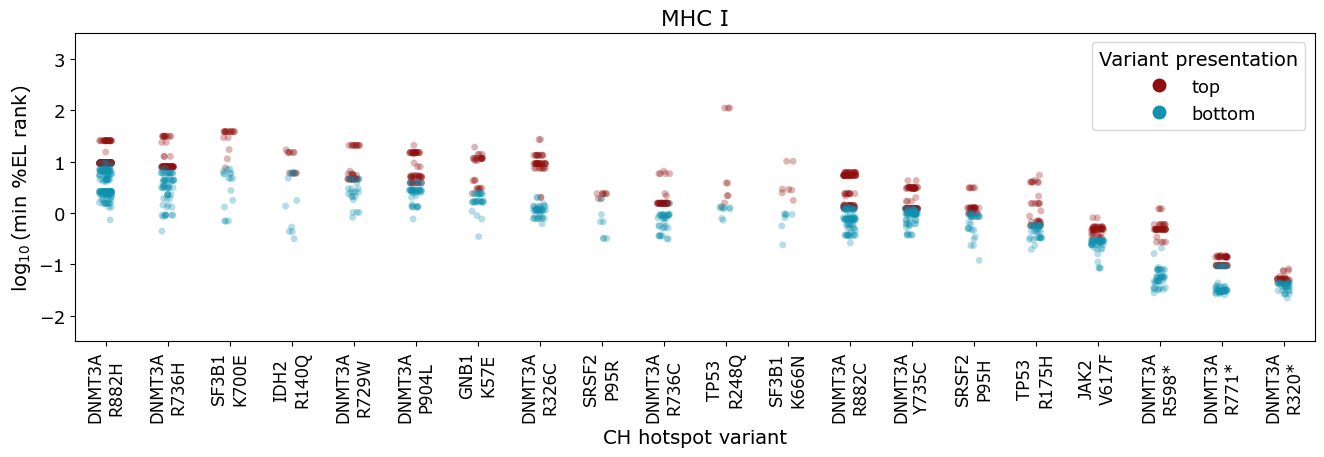

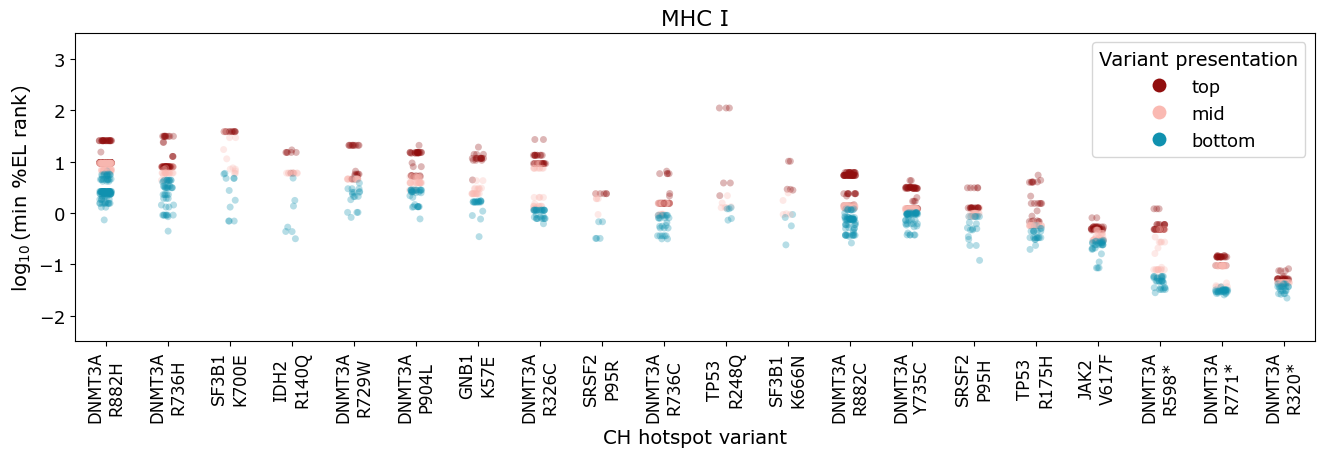

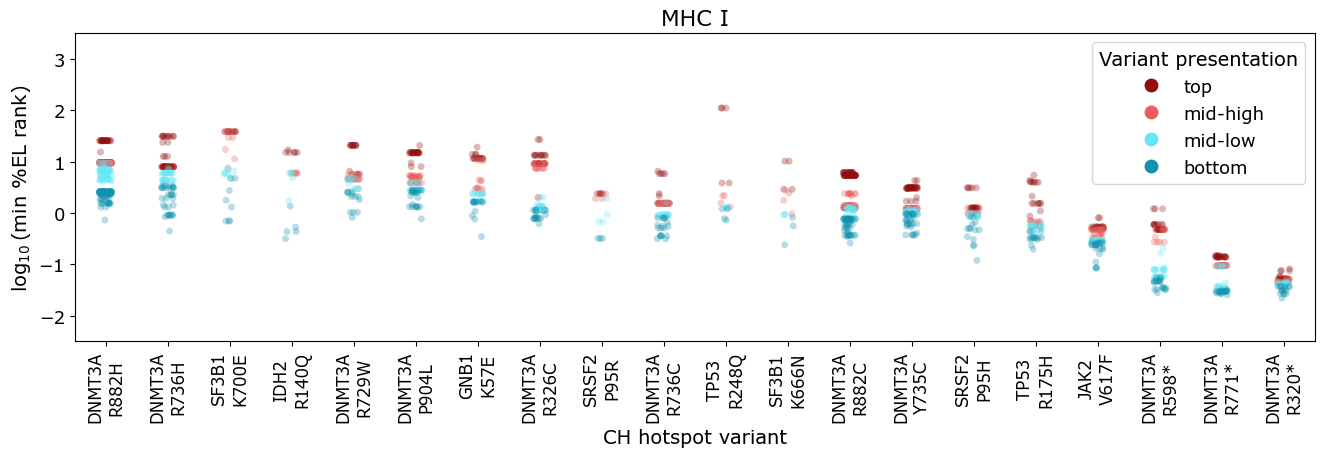

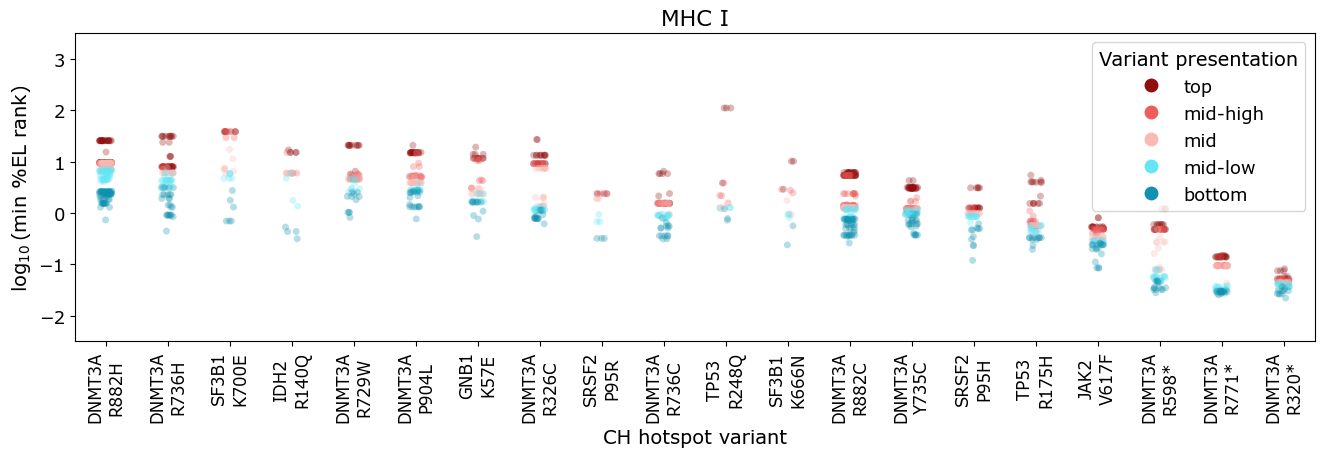

In [ ]:
# get plots 
plot_ranks(scores_groups2_eqsize, 'gene_var2', 'score', 'group_name', colors2, order, 'jitter', 2, hue_order2)
plot_ranks(scores_groups3_eqsize, 'gene_var2', 'score', 'group_name', colors3, order, 'jitter', 3, hue_order3)
plot_ranks(scores_groups4_eqsize, 'gene_var2', 'score', 'group_name', colors4, order, 'jitter', 4, hue_order4)
plot_ranks(scores_groups5_eqsize, 'gene_var2', 'score', 'group_name', colors5, order, 'jitter', 5, hue_order5)

In [ ]:

# add number of cases to the dataframe to be able to include on the x axis 

df_with_nr_carriers = df_compare_to_ref2[['gene_var2', 'CH variant3']]

df_groups2_eqsize = df_groups2_eqsize.rename_axis(index={'gene_var2': 'index'})
df_groups3_eqsize = df_groups3_eqsize.rename_axis(index={'gene_var2': 'index'})
df_groups4_eqsize = df_groups4_eqsize.rename_axis(index={'gene_var2': 'index'})
df_groups5_eqsize = df_groups5_eqsize.rename_axis(index={'gene_var2': 'index'})

df_groups2_eqsize_with_nr = pd.merge(df_groups2_eqsize, df_with_nr_carriers, on = 'gene_var2')
df_groups3_eqsize_with_nr = pd.merge(df_groups3_eqsize, df_with_nr_carriers, on = 'gene_var2')
df_groups4_eqsize_with_nr = pd.merge(df_groups4_eqsize, df_with_nr_carriers, on = 'gene_var2')
df_groups5_eqsize_with_nr = pd.merge(df_groups5_eqsize, df_with_nr_carriers, on = 'gene_var2')

df_groups2_eqsize_with_nr = df_groups2_eqsize_with_nr[~df_groups2_eqsize_with_nr.duplicated()]
df_groups3_eqsize_with_nr = df_groups3_eqsize_with_nr[~df_groups3_eqsize_with_nr.duplicated()]
df_groups4_eqsize_with_nr = df_groups4_eqsize_with_nr[~df_groups4_eqsize_with_nr.duplicated()]
df_groups5_eqsize_with_nr = df_groups5_eqsize_with_nr[~df_groups5_eqsize_with_nr.duplicated()]

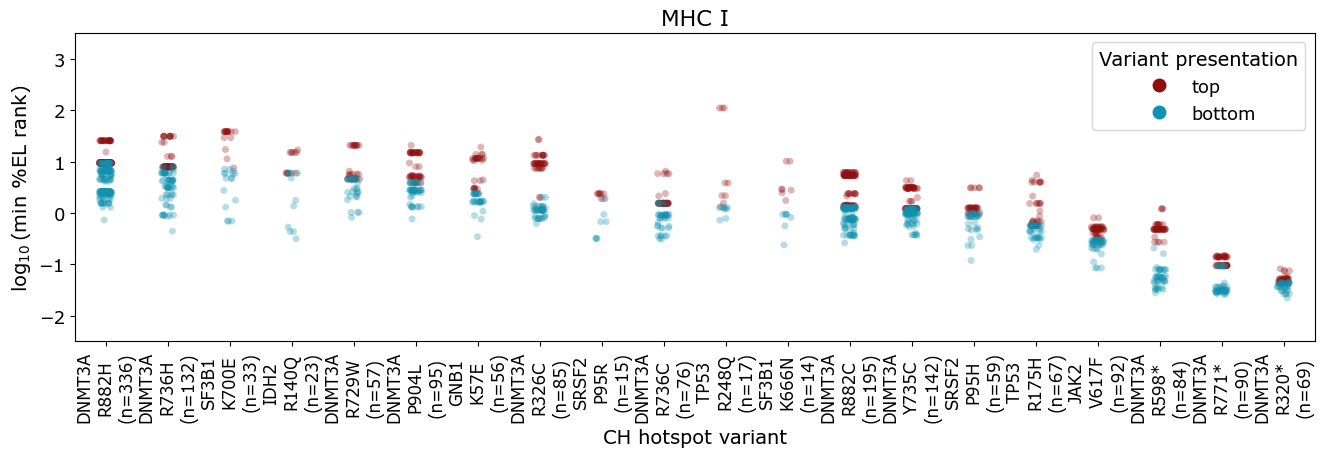

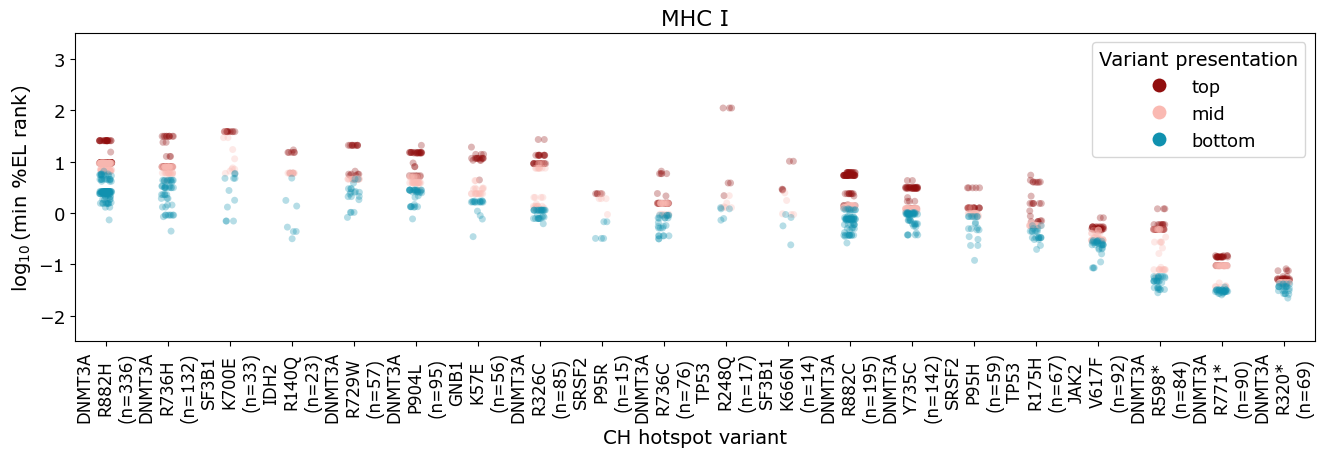

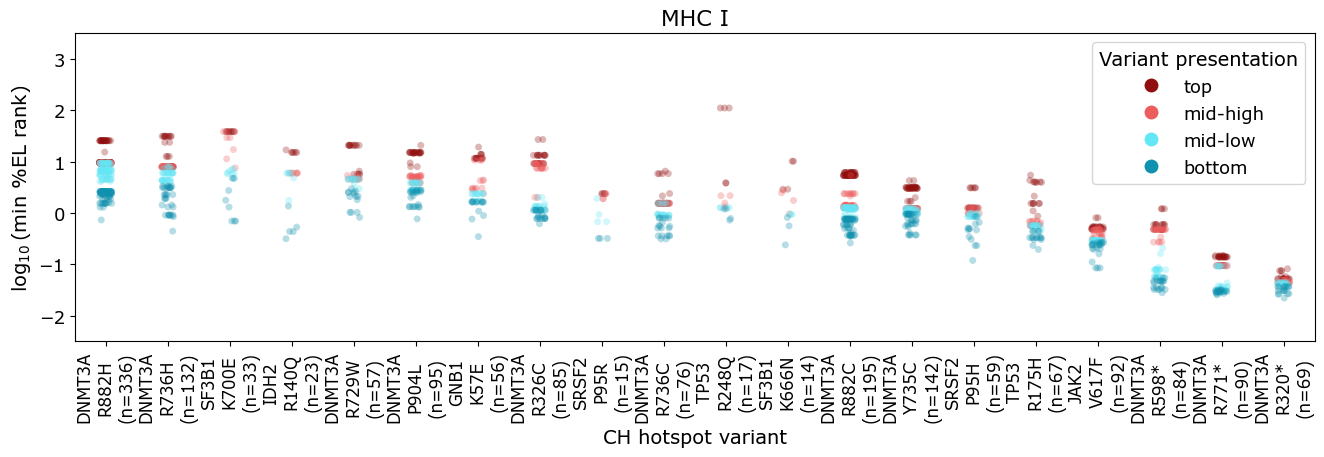

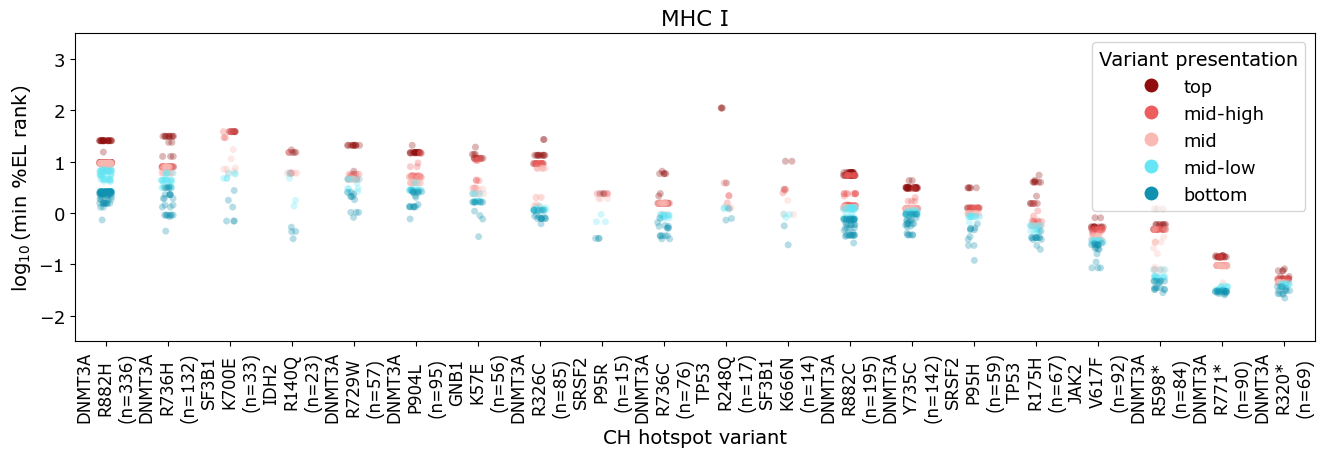

In [ ]:

# the same plots but with number of carriers indicates on the x axis
plot_ranks(df_groups2_eqsize_with_nr, 'CH variant3', 'score', 'group_name', colors2, order_3, 'jitter', 2, hue_order2)
plot_ranks(df_groups3_eqsize_with_nr, 'CH variant3', 'score', 'group_name', colors3, order_3, 'jitter', 3, hue_order3)
plot_ranks(df_groups4_eqsize_with_nr, 'CH variant3', 'score', 'group_name', colors4, order_3, 'jitter', 4, hue_order4)
plot_ranks(df_groups5_eqsize_with_nr, 'CH variant3', 'score', 'group_name', colors5, order_3, 'jitter', 5, hue_order5)


In [ ]:

# specify order of levels in group descriptors
cat_type2 = pd.CategoricalDtype(categories=['top', 'bottom'], ordered=True)
df_groups2_eqsize['group_name'] = df_groups2_eqsize['group_name'].astype(cat_type2)
df_groups2_eqsize['group_name'] = df_groups2_eqsize['group_name'].astype('category')

cat_type3 = pd.CategoricalDtype(categories=['top', 'mid', 'bottom'], ordered=True)
df_groups3_eqsize['group_name'] = df_groups3_eqsize['group_name'].astype(cat_type3)
df_groups3_eqsize['group_name'] = df_groups3_eqsize['group_name'].astype('category')

cat_type4 = pd.CategoricalDtype(categories=['top', 'mid-high', 'mid-low', 'bottom'], ordered=True)
df_groups4_eqsize['group_name'] = df_groups4_eqsize['group_name'].astype(cat_type4)
df_groups4_eqsize['group_name'] = df_groups4_eqsize['group_name'].astype('category')

cat_type5 = pd.CategoricalDtype(categories=['top', 'mid-high', 'mid', 'mid-low', 'bottom'], ordered=True)
df_groups5_eqsize['group_name'] = df_groups5_eqsize['group_name'].astype(cat_type5)
df_groups5_eqsize['group_name'] = df_groups5_eqsize['group_name'].astype('category')

In [ ]:

# define function to plot cumulative probability
def plot_cumulative(data, x, y, hue, colors, xlabel, ylabel, var, score, score_title, name):

    var_name = var.split('_')[0:2]
    var_name = ' '.join(var_name)

    nr_cases = data.shape[0]

    plt.figure(figsize=(4,4)) 
    sns.lineplot(x=x, y=y, data=data, hue=hue, palette=colors, legend = True)
    sns.scatterplot(x=x, y=y, data=data, hue=hue, palette=colors, legend = False, alpha = 0.3, linewidth=0)

    # specify title and axes labels 
    plt.title(f'{var_name} (n={nr_cases})', fontsize = 12)
    plt.xlabel(xlabel, fontsize = 10)
    plt.ylabel(ylabel, fontsize = 10)

    # convert both axes to log scale 
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')

    # adjust legend 
    legend = plt.legend()
    legend.prop.set_size(10) 
    plt.legend(title = 'Variant presentation', loc = 'lower left', fontsize = 10, title_fontsize = 11)

    # specify ticks on the x axis 
    x_ticks = [1, 3, 10, 30]
    plt.xticks(x_ticks, x_ticks, fontsize = 9)

    y_ticks = [1, 0.3, 0.1, 0.03]
    plt.yticks(y_ticks, y_ticks, fontsize = 9)
    
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_UKBB_VAF_{hue}_{name}_{score}_{var}.pdf', bbox_inches='tight')
    plt.close()

In [53]:

# plots scores for each group on the same plot 
# note: an alternative is to split by thresholds for binding  
# script to do this is included in the complete analysis, but I am not using this way due to issues described there 

# for extreme groups in each split 
dfs_list = ['df_groups2_eqsize', 'df_groups3_eqsize', 'df_groups4_eqsize', 'df_groups5_eqsize']

for name in dfs_list:

    df = globals()[name]

    score = df.score_type[0]
    score_title = score.replace('_', ' ')
    nr_groups = re.search(r'\d', name).group() # find the digit in the df name 

    df['VAF_percent'] = df['VAF'] * 100

    # specify the colors 
    if nr_groups == '2':
        colors = {'top': col0, 'bottom': col3}
    elif nr_groups == '3':
        colors = {'top': col0, 'mid': col1b, 'bottom': col3}
    elif nr_groups == '4':
        colors = {'top': col0, 'mid-high': col1, 'mid-low': col2, 'bottom': col3}
    elif nr_groups == '5':
        colors = {'top': col0, 'mid-high': col1, 'mid': col1b, 'mid-low': col2, 'bottom': col3}

    variants = df['gene_var'].unique()

    # plot for each variant separately 
    for var in variants: 

        data = df[df['gene_var'] == var]
        data = data.sort_values(by='VAF')
        
        N = data.shape[0]

        # add number of people in each category 
        data['group_size'] = data.groupby('group_name')['group_name'].transform('count')
        data['index_vaf_group'] = data.groupby('group_name')['VAF'].rank(ascending=False) # index by VAF
        data['fraction_index_presenter_group'] = data['index_vaf_group'] / data['group_size']
        
        plot_cumulative(data, 'VAF_percent', 'fraction_index_presenter_group', 'group_name', colors, 'VAF (%)', f'Cumulative probability', var, score, score_title, f'{nr_groups}_groups_eqsize_allon1')

    # plot aggregate for all variants
    df = df.sort_values(by='VAF')

    df['group_size'] = df.groupby('group_name')['group_name'].transform('count')
    df['index_vaf_group'] = df.groupby('group_name')['VAF'].rank(ascending=False) # index by VAF
    df['fraction_index_presenter_group'] = df['index_vaf_group'] / df['group_size']
    
    plot_cumulative(df, 'VAF_percent', 'fraction_index_presenter_group', 'group_name', colors, 'VAF (%)', f'Cumulative probability', 'All_variants', score, score_title, f'{nr_groups}_groups_eqsize_allon1') 

# Test 3: MHC genotype to predict CH risk 

In [54]:


# define a new function just to do it for one variant 
def find_best_score_one_variant_log_ref_ch(row, df, param, variant):
    
    '''
    The same function but log scores 
    the only allowed parameters are %Rank_EL and %Rank_BA
    we want -1 * log(score) so the highest score if the most "immunogenic" (best binding) one
    '''
    
    hlas = row.index[1:-1][row[1:-1] >= 1] # select alleles which each Person (row) carrie
    
    scores = {} # initialise empty dictionaries

    if param == "%Rank_EL":

        # take maximum of the negative log score 
        best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == variant, hlas].values[0]))
        scores[f'score_{variant}'] = best_value
        return pd.Series(scores)

    elif param == "%Rank_BA":
        
        # take maxium of the negative log score 
        best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == variant, hlas].values[0]))
        scores[f'score_{variant}'] = best_value
        return pd.Series(scores)

    elif param == "Aff_nM":
        
        # take maxium of the negative log score (low aff = more immunogenic)
        best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == variant, hlas].values[0]))
        scores[f'score_{variant}'] = best_value
        return pd.Series(scores)


In [61]:

# define a function to split people into groups based on MHC presentation score 

def split_equal_groups_by_varscore(df, num_groups, var):

    '''
    first, assign a rank to everyone based on score
    the highest score = the lowest rank (ie highest score means you get rank 1)
    if two people have the same score, assign consecutive ranks 
    '''
    
    # first, determine the number of samples
    total_samples = len(df)

    # now, determine the number of samples in each group
    samples_per_group = total_samples // num_groups
    remainder = total_samples % num_groups
    group_sizes = [samples_per_group + 1 if i < remainder else samples_per_group for i in range(num_groups)] # add one person if there is a reminder 
    
    # now, assign the group based on the rank 
    group_assignments = []
    group_number = 1
    start = 0
    for size in group_sizes:
        end = start + size
        group_assignments.extend([group_number] * (end - start))
        start = end
        group_number += 1

    # Add a new column 'group' to the DataFrame indicating the group assignment for each row
    return group_assignments


In [55]:

# cases who have CH with a genotyped variant (from one of the ones we were looking at) are in batch_gene_vars 

ch_sampleids = batch_gene_vars_hla_10['Person_ID']
ukbb_no_ch = df_clean_hla1[~df_clean_hla1['Person_ID'].isin(ch_sampleids)]
hla_ukbb = ukbb_no_ch.filter(regex='\d').columns # identify HLA alleles carried by non-CH-individuals in the UKBB data

# prepare dataset with predictions (now just from NetMHC)
scores_netmhc_elrank = scores_netmhc[['HLA_formatted', '%Rank_EL', 'gene_var_gt']]
scores_netmhc_elrank_wide = pd.pivot(scores_netmhc_elrank, index='gene_var_gt', columns='HLA_formatted', values='%Rank_EL')

hla_intersect = scores_netmhc_elrank_wide.columns[scores_netmhc_elrank_wide.columns.isin(hla_ukbb)]
hla_intersect_list = hla_intersect.tolist() # select predictions for alleles which are available in NetMHC / PRIME

pred_sub_wide = scores_netmhc_elrank_wide[hla_intersect_list + scores_netmhc_elrank_wide.columns[scores_netmhc_elrank_wide.columns.str.contains('gene_var_gt')].tolist()]

ukbb_no_ch_hla = ukbb_no_ch[hla_intersect]
ukbb_no_ch = pd.concat([ukbb_no_ch['Person_ID'], ukbb_no_ch_hla], axis = 1)
ukbb_no_ch.head()

ids_non_carriers_healthy = ukbb_no_ch.Person_ID.unique().tolist()
print('Number of healthy (non-CH) individuals examined:', len(ids_non_carriers_healthy))

# okay so now we have a dataset for everyone who does NOT have CH
# and for all of them, we have their alleles for which we can make predictions

pred_sub_wide['gene_var_gt'] = pred_sub_wide.index

Number of healthy (non-CH) individuals examined: 441910


In [56]:
# select only HLAs for which we have predictions
df_clean_hla1_hla = df_clean_hla1[hla_intersect]
df_clean_hla1_hla_sel = pd.concat([df_clean_hla1['Person_ID'], df_clean_hla1_hla], axis = 1)

In [57]:

# subset the dataframe to only include individuals who were actually screened for CH
batch_all['batch_number'] = batch_all['batch'].apply(lambda x: [int(num) for num in re.findall(r'\d+', x)])
batch_numbers_examined = set(batch_all['batch_number'].sum()) 
print('Batches that were examined for variants:', batch_numbers_examined)

all_dataframes = [f'batch_{i}_ids' for i in range(11, 61)]
selected_ids = []

# Iterate through all df name 
for df_name in all_dataframes:
    number = int(re.search(r'\d+', df_name).group())
    # check if number matches numbers of batches examined 
    if number in batch_numbers_examined:        
        selected_ids.append(globals()[df_name])

ids_examined = pd.concat(selected_ids, ignore_index=True)
print('Number of samples examined for variants:', ids_examined.shape[0])

ids_examined_list = ids_examined['sample_ID'].tolist()
ids_examined_list = [int(id) for id in ids_examined_list]

Batches that were examined for variants: {11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}
Number of samples examined for variants: 99597


In [58]:

df_clean_hla1_hla_sel = df_clean_hla1_hla_sel[df_clean_hla1_hla_sel['Person_ID'].isin(ids_examined_list)]
df_clean_hla1_hla_sel.head() # note that this 

,Person_ID,A_101,A_102,A_103,A_1101,A_1102,A_1103,A_201,A_202,A_203,...,C_403,C_407,C_501,C_602,C_701,C_702,C_704,C_801,C_802,C_804
4,1118855,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1734232,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14,1539760,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
15,1396487,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19,1759529,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:

# define functions to compare groups

def percentage_difference(group, nr_groups):

    x_a = group.loc[group[f'groups_{nr_groups}'] == 1, 'CH_variant_positive'].iloc[0]  # first group 
    x_b = group.loc[group[f'groups_{nr_groups}'] == nr_groups, 'CH_variant_positive'].iloc[0]  # last group 
    
    result = (x_b - x_a) / x_a * 100
    return result

def normalized_difference(group, nr_groups):

    x_a = group.loc[group[f'groups_{nr_groups}'] == 1, 'CH_variant_positive'].iloc[0]  # first group 
    x_b = group.loc[group[f'groups_{nr_groups}'] == nr_groups, 'CH_variant_positive'].iloc[0]  # last group 
    num_observations = group['count']   # Number of observations in this category
    
    result = (x_b - x_a) / num_observations * 100
    return result

In [62]:
# loop for all variants

scores_2groups = {}
scores_for_each_var_ukbb = {}

for var in variants_to_examine:
    
    # for everyone in the UKBB, add binding score for each variant based on their MHC genotype
    # note this is for everyone, carrier or not
    df_all_ukbb_scores = pd.concat([df_clean_hla1_hla_sel, df_clean_hla1_hla_sel.apply(find_best_score_one_variant_log_ref_ch, df=pred_sub_wide, param=param, variant = f'{var}_ch', axis=1)], axis=1)
    scores_for_each_var_ukbb[var] = df_all_ukbb_scores[f'score_{var}_ch'] # add this so we can later correlate with immunogenicity

    # order the df by rank
    df_all_ukbb_scores['rank'] = df_all_ukbb_scores[f'score_{var}_ch'].rank(method='first', ascending=False)
    df_all_ukbb_scores_sort = df_all_ukbb_scores.sort_values(by = 'rank')

    # split people into 2 groups for each variant (how strongly they bind)
    df_all_ukbb_scores_sort['groups_2'] = split_equal_groups_by_varscore(df_all_ukbb_scores_sort, num_groups = 2, var = var)

    # okay now we need to add a column to indicate if that person has CH driven by this variant
    # identify IDs of people with the variant
    ids_var = batch_gene_vars[batch_gene_vars['gene_var']==var].Person_ID.tolist()
    df_all_ukbb_scores_sort[f'{var}_positive'] = df_all_ukbb_scores_sort.Person_ID.isin(ids_var) # added True if someone has the variant, False otherwise 

    # calculate % of people in each of the 5 or 10 groups (as % of total CH positive cases)
    counts2 = df_all_ukbb_scores_sort.groupby('groups_2')[f'{var}_positive'].sum().reset_index()
    counts2['percentage_all_cases'] = counts2[f'{var}_positive'] / counts2[f'{var}_positive'].sum() * 100
    
    # add data to the dictionary 
    scores_2groups[var] = counts2

In [63]:
# get dfs
scores_2groups_df = pd.DataFrame()

for key, value in scores_2groups.items():
    temp_df = scores_2groups[key]
    temp_df['gene_var'] = key
    temp_df.rename(columns = {f'{key}_positive':'CH_variant_positive'}, inplace = True)
    scores_2groups_df = pd.concat([scores_2groups_df, temp_df], axis=0)

# I think one way we can analyse this is for each variant, plot the difference between top and bottom group, normalized by the total nr of people
genevar_counts = pd.DataFrame(batch_gene_vars_hla_10.gene_var.value_counts().reset_index())
scores_2groups_counts = pd.merge(scores_2groups_df, genevar_counts, on = 'gene_var')

# Group by Category and apply the custom calculation function
result_2groups1 = pd.DataFrame(scores_2groups_counts.groupby('gene_var').apply(percentage_difference, nr_groups = 2))
result_2groups2 = pd.DataFrame(scores_2groups_counts.groupby('gene_var').apply(normalized_difference, nr_groups = 2))
result_2groups = pd.merge(result_2groups1, result_2groups2, on = 'gene_var')
result_2groups = result_2groups.groupby('gene_var').first().reset_index()
result_2groups.columns.values[1] = 'percentage_diff'
result_2groups.columns.values[2] = 'norm_diff'

In [64]:
# each group had 45237 observations (we have 90474 people in total and we split them into 2)
scores_2groups_df['CH_variant_negative'] = ( df_clean_hla1_hla_sel.shape[0]/2 - scores_2groups_df['CH_variant_positive']).astype(int)
scores_2groups_df['total'] = int(df_clean_hla1_hla_sel.shape[0]/2 )
scores_2groups_df['Group'] = scores_2groups_df['groups_2'].map({1: 'better presenters', 2: 'worse presenters'})
scores_2groups_df['gene_var2'] = scores_2groups_df['gene_var'].str.replace('_', '\n')

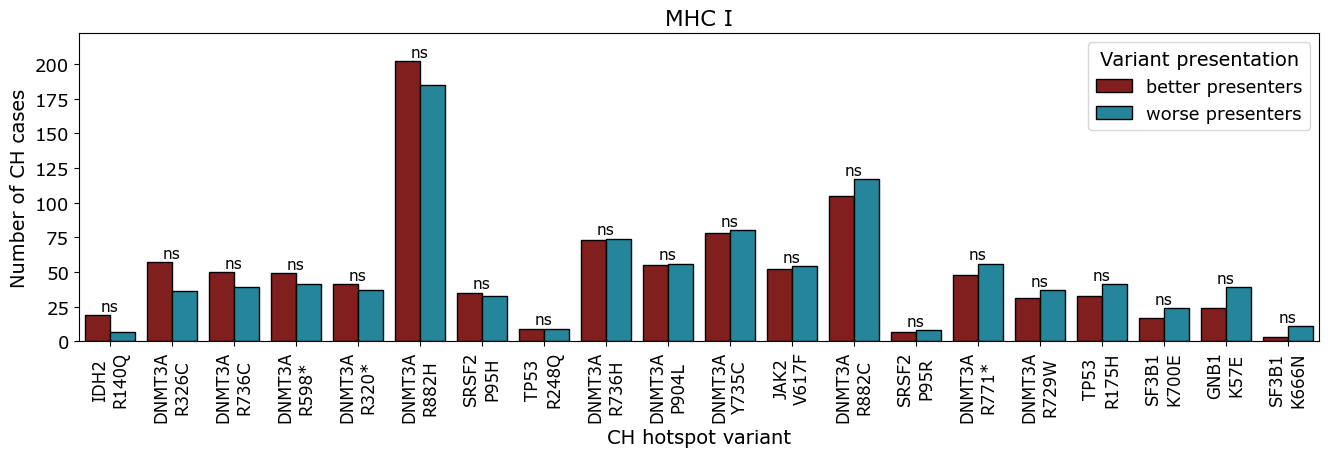

In [65]:
# simpler plot 
order_percent2 = result_2groups.sort_values(by = 'percentage_diff').gene_var.tolist()
order_norm2 = result_2groups.sort_values(by = 'norm_diff').gene_var.tolist()
order_percent2 = [x.replace('_', '\n') for x in order_percent2]
order_norm2 = [x.replace('_', '\n') for x in order_norm2]

from scipy.stats import chi2_contingency

colors = [col0, col3]

plt.figure(figsize = (16, 4))
sns.barplot(data = scores_2groups_df, x = 'gene_var2', y = 'CH_variant_positive', hue = 'Group', palette = colors, edgecolor = 'black', order = order_percent2)
plt.xlabel(f'CH hotspot variant', fontsize = 14)
plt.ylabel('Number of CH cases', fontsize = 14)
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 13)
plt.title('MHC I', fontsize = 16)
plt.ylim(0, scores_2groups_df['CH_variant_positive'].max()+20)

# Chi-squared test 
for i, var in enumerate(order_percent2):

    small_df = scores_2groups_df[scores_2groups_df['gene_var2'] == var]
    observed = [[small_df[small_df['groups_2'] == 1].total, small_df[small_df['groups_2'] == 1].CH_variant_positive], 
                [small_df[small_df['groups_2'] == 2].total, small_df[small_df['groups_2'] == 2].CH_variant_positive]]
    max_value = small_df[['CH_variant_positive']].max()
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(observed)
    p_value = p_value  # correction for multiple testing 

    significance = ''
    if p_value > (0.05 / len(order_percent2)): # correction for multiple testing 
        significance = 'ns'
    elif p_value < (0.01 / len(order_percent2)):
        significance = '**'
    else:
        significance = '*'
    plt.text(i, max_value+1, significance, ha='center', va='bottom', fontsize=11)
    
plt.legend(title = 'Variant presentation', markerscale = 2, loc = 'upper right', fontsize = 13, title_fontsize = 14)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_compare_absolute_numbers_ordered_by_diff.pdf', bbox_inches='tight')


In [66]:
order_by_total = scores_2groups_df.groupby('gene_var2')['CH_variant_positive'].sum().reset_index()
order_by_total = order_by_total.sort_values(by = 'CH_variant_positive', ascending = False).gene_var2.tolist()

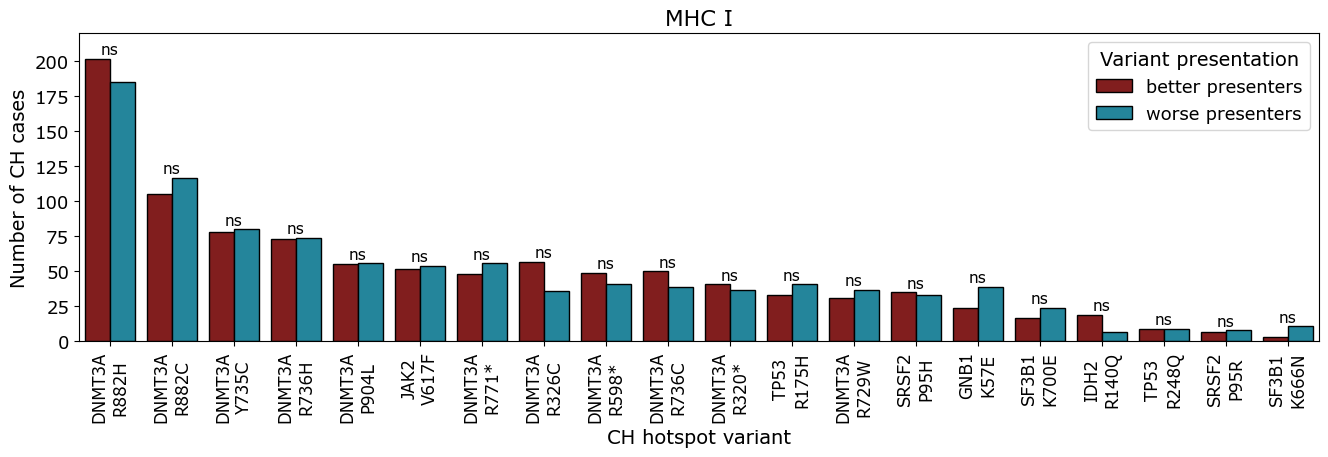

In [67]:
# plot by order of total nr cases 
colors = [col0, col3]

plt.figure(figsize = (16, 4))
sns.barplot(data = scores_2groups_df, x = 'gene_var2', y = 'CH_variant_positive', hue = 'Group', palette = colors, edgecolor = 'black', order = order_by_total)
plt.xlabel(f'CH hotspot variant', fontsize = 14)
plt.ylabel('Number of CH cases', fontsize = 14)
plt.ylim(0, 220)
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 13)
plt.title('MHC I', fontsize = 16)

# Chi-squared test 
for i, var in enumerate(order_by_total):

    small_df = scores_2groups_df[scores_2groups_df['gene_var2'] == var]
    observed = [[small_df[small_df['groups_2'] == 1].total, small_df[small_df['groups_2'] == 1].CH_variant_positive], 
                [small_df[small_df['groups_2'] == 2].total, small_df[small_df['groups_2'] == 2].CH_variant_positive]]
    
    max_value = small_df[['CH_variant_positive']].max()
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(observed)

    significance = ''
    if p_value > (0.05 / len(order_percent2)): # correction for multiple testing
        significance = 'ns'
    elif p_value < (0.01 / len(order_percent2)):
        significance = '**'
    else:
        significance = '*'
    plt.text(i, max_value+1, significance, ha='center', va='bottom', fontsize=11)

plt.legend(title = 'Variant presentation', markerscale = 2, loc = 'upper right', fontsize = 13, title_fontsize = 14)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_compare_absolute_numbers_ordered_by_abs.pdf', bbox_inches='tight')

# Test 4: split by absolute threshold

In [68]:
# create a dataframe with scores for everyone in the UKBB 
scores_each_var_df = pd.DataFrame()

for key, value in scores_for_each_var_ukbb.items():
    temp_df = scores_for_each_var_ukbb[key].reset_index()
    temp_df['gene_var'] = key
    temp_df.rename(columns = {f'score_{key}_ch':'score'}, inplace = True)
    scores_each_var_df = pd.concat([scores_each_var_df, temp_df], axis=0)

scores_each_var_df

,index,score,gene_var
0,4,0.419075,DNMT3A_R882H
1,9,0.982967,DNMT3A_R882H
2,14,0.970616,DNMT3A_R882H
3,15,0.189096,DNMT3A_R882H
4,19,0.970616,DNMT3A_R882H
...,...,...,...
90469,488357,-0.028571,SF3B1_K666N
90470,488359,0.463442,SF3B1_K666N
90471,488361,-0.250420,SF3B1_K666N
90472,488369,0.463442,SF3B1_K666N


In [1]:
1809480 / 20

90474.0

In [69]:
# Drop rows with non-numeric score columns
scores_each_var_df['score'] = pd.to_numeric(scores_each_var_df['score'], errors='coerce')
scores_each_var_df = scores_each_var_df.dropna(subset=['score'])
scores_each_var_df['gene_var2'] = scores_each_var_df['gene_var'].str.replace('_', '\n')

In [70]:

# specify order (for all)
scores_each_var_df['median_score'] = scores_each_var_df.groupby('gene_var2').score.transform('median')
order_all = scores_each_var_df.sort_values(by = 'median_score', ascending = False).gene_var2.unique().tolist()


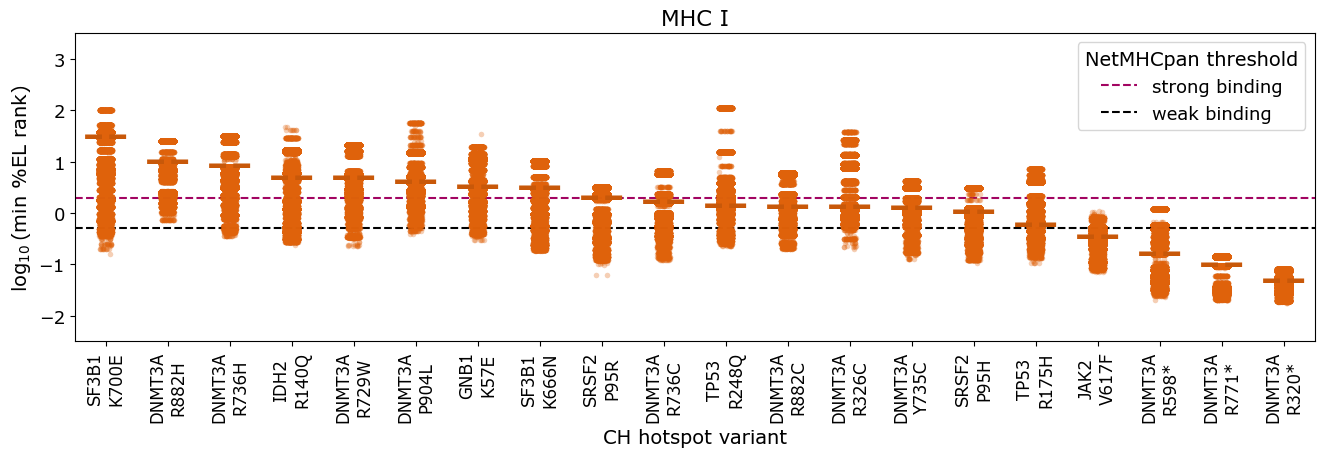

In [71]:
# plot scores
plt.figure(figsize = (16,4))
sns.stripplot(x = 'gene_var2', y = 'score', data = scores_each_var_df, color = '#df620b', alpha = 0.3, size = 4, order = order_all)

# add thresholds
plt.axhline(y=-1*np.log10(0.5), color='#a20461', linestyle='--', label='strong binding')
plt.axhline(y=-1*np.log10(2), color='black', linestyle='--', label='weak binding')

for i, var in enumerate(order_all):
    median = scores_each_var_df[scores_each_var_df['gene_var2']==var].score.median()
    plt.text(i, median, '--',  ha='center', va='center', fontsize = 40, color = '#c85809')

plt.xlabel(f'CH hotspot variant', fontsize = 14)
plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 14)
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 13)
plt.title('MHC I', fontsize = 16)
plt.ylim(-2.5, 3.5)
plt.legend(title = 'NetMHCpan threshold', loc = 'upper right', fontsize = 13, title_fontsize = 14)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_variant_pres_scores_all_ukbb.pdf', bbox_inches='tight')

In [72]:
# okay now for each variant, let's first calculate people at each category 
bins = [-float('inf'), -1*np.log10(2), -1*np.log10(0.5), float('inf')]
labels = ['no binding', 'weak binding', 'strong binding']

# Categorize scores into bins
scores_each_var_df['score_bin'] = pd.cut(scores_each_var_df['score'], bins=bins, labels=labels)

# Group by category and score bins, then count observations
grouped_df = scores_each_var_df.groupby(['gene_var2', 'score_bin']).size().unstack(fill_value=0)

# Create a new DataFrame with desired columns
scores_each_var_df_bins = grouped_df.reset_index()
scores_each_var_df_bins.columns.name = None  # Remove the name of columns index
scores_each_var_df_bins.columns = ['gene_var2', 'no binding', 'weak binding', 'strong binding']

scores_each_var_df_bins.head()

,gene_var2,no binding,weak binding,strong binding
0,DNMT3A\nP904L,22,11388,79064
1,DNMT3A\nR320*,90474,0,0
2,DNMT3A\nR326C,96,50875,39503
3,DNMT3A\nR598*,75093,15381,0
4,DNMT3A\nR729W,268,8632,81574


In [73]:

# okay, now we are doing the same thing for carriers 
scores_each_var_df_carriers = ch_all_el_rank_log_melted_sort[ch_all_el_rank_log_melted_sort['is_variant_present']==True]
scores_each_var_df_carriers = scores_each_var_df_carriers[['Person_ID', 'gene_var2', 'value']]
scores_each_var_df_carriers.rename(columns = {'value':'score'}, inplace = True)

# add score bins
bins = [-float('inf'), -1*np.log10(2), -1*np.log10(0.5), float('inf')]
labels = ['no binding', 'weak binding', 'strong binding']
scores_each_var_df_carriers['score_bin'] = pd.cut(scores_each_var_df_carriers['score'], bins=bins, labels=labels)

grouped_df_carriers = scores_each_var_df_carriers.groupby(['gene_var2', 'score_bin']).size().unstack(fill_value=0)
scores_each_var_df_bins_carriers = grouped_df_carriers.reset_index()
scores_each_var_df_bins_carriers.columns.name = None  # Remove the name of columns index
scores_each_var_df_bins_carriers.columns = ['gene_var2', 'no binding', 'weak binding', 'strong binding']

# merge all together and calculate values for non-carriers
merged_df = scores_each_var_df_bins.merge(scores_each_var_df_bins_carriers, on='gene_var2', suffixes=('_population', '_carriers'))
merged_df['no binding_noncarriers'] = merged_df['no binding_population'] - merged_df['no binding_carriers']
merged_df['weak binding_noncarriers'] = merged_df['weak binding_population'] - merged_df['weak binding_carriers']
merged_df['strong binding_noncarriers'] = merged_df['strong binding_population'] - merged_df['strong binding_carriers']

merged_df.head()

,gene_var2,no binding_population,weak binding_population,strong binding_population,no binding_carriers,weak binding_carriers,strong binding_carriers,no binding_noncarriers,weak binding_noncarriers,strong binding_noncarriers
0,DNMT3A\nP904L,22,11388,79064,0,9,86,22,11379,78978
1,DNMT3A\nR320*,90474,0,0,69,0,0,90405,0,0
2,DNMT3A\nR326C,96,50875,39503,0,40,45,96,50835,39458
3,DNMT3A\nR598*,75093,15381,0,73,11,0,75020,15370,0
4,DNMT3A\nR729W,268,8632,81574,0,5,52,268,8627,81522


In [74]:

# do mann-whitney test to compare population (non-carriers) and carriers scores 
pvalues_mwu = {}
cat_series = pd.Series(['Carrier', 'Non-carrier'])
df_scores_all_plot = pd.DataFrame()

for var in order_all:
    carrier_scores = scores_each_var_df_carriers[scores_each_var_df_carriers['gene_var2']==var].score.tolist()
    all_scores = scores_each_var_df[scores_each_var_df['gene_var2']==var].score.tolist()

    # Remove elements from x only once if they appear once in y
    from collections import Counter 
    counts = Counter(carrier_scores)

    noncarrier_scores = []
    for x in all_scores:
        if counts[x]:
            counts[x] -= 1
        else:
            noncarrier_scores.append(x)

    scores_series = pd.Series(carrier_scores + noncarrier_scores).reset_index(drop=True)
    repetitions = [len(carrier_scores), len(noncarrier_scores)]
    cat_series_rep = pd.Series(cat_series.repeat(repetitions)).reset_index(drop=True)
    df_x = pd.DataFrame({'score': scores_series, 'CH status': cat_series_rep})
    df_x['gene_var2'] = var

    df_scores_all_plot = pd.concat([df_scores_all_plot, df_x], axis = 0)

    statistic, p_value = mannwhitneyu(carrier_scores, noncarrier_scores)
    pvalues_mwu[var] = p_value


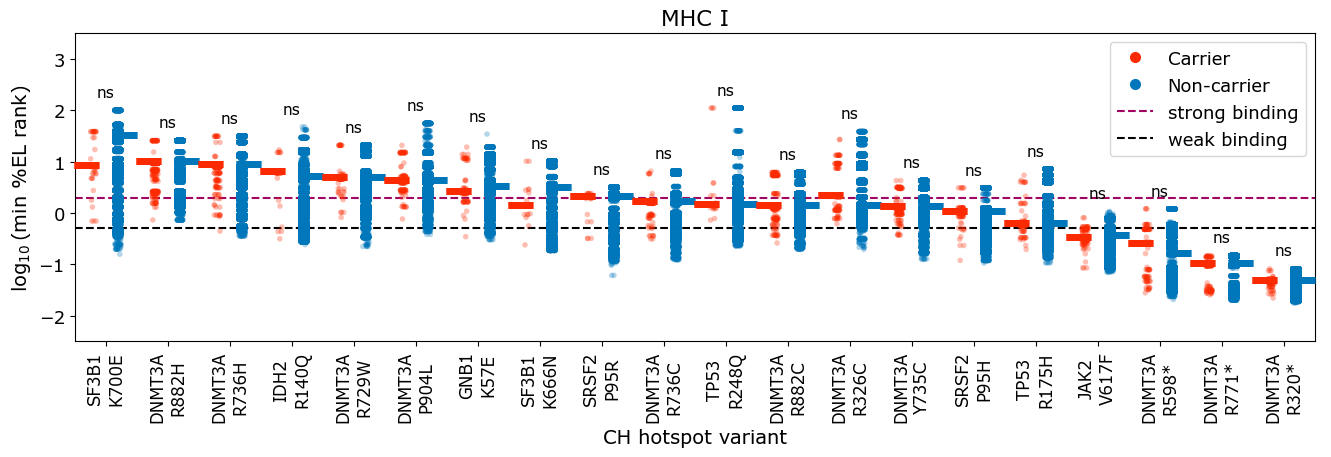

In [75]:
# plot carriers vs ALL non-carriers in the dataset examined (aka the ~99k people)
colors = [red0, blue0]

# plot scores
plt.figure(figsize = (16,4))
sns.stripplot(x = 'gene_var2', y = 'score', hue = 'CH status', dodge = True, data = df_scores_all_plot, palette = colors, alpha = 0.3, size = 4, order = order_all)

# add thresholds
plt.axhline(y=-1*np.log10(0.5), color='#a20461', linestyle='--', label='strong binding')
plt.axhline(y=-1*np.log10(2), color='black', linestyle='--', label='weak binding')

for i, var in enumerate(order_all):
    median_carr = df_scores_all_plot[(df_scores_all_plot['gene_var2']==var) & (df_scores_all_plot['CH status']=='Carrier')].score.median()
    median_ncarr = df_scores_all_plot[(df_scores_all_plot['gene_var2']==var) & (df_scores_all_plot['CH status']=='Non-carrier')].score.median()
    plt.text(i, median_carr, '-',  ha='right', va='center', fontsize = 60, color = red0)
    plt.text(i, median_ncarr, '-',  ha='left', va='center', fontsize = 60, color = blue0)

plt.xlabel(f'CH hotspot variant', fontsize = 14)
plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 14)
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 13)
plt.title('MHC I', fontsize = 16)
plt.ylim(-2.5, 3.5)

for i, var in enumerate(order_all):
    p_value = pvalues_mwu[var]
    max_value = df_scores_all_plot[df_scores_all_plot['gene_var2']==var].score.max()
    significance = ''
    if p_value > (0.05 / len(order_all)):
        significance = 'ns'
    elif p_value < (0.01 / len(order_all)):
        significance = '**'
    else:
        significance = '*'
    plt.text(i, 0.2+max_value, significance, ha='center', va='bottom', fontsize=11)

plt.legend(markerscale = 2, loc = 'upper right', fontsize = 13, title_fontsize = 14)
legend = plt.gca().get_legend()
for handle, color in zip(legend.legendHandles, colors):
    handle.set_color(color)
for lh in legend.legendHandles:
    lh.set_alpha(1)
    
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_variant_pres_scores_all_ukbb_cnc.pdf', bbox_inches='tight')

In [76]:

# do a chi-squared test to compare distribution

from scipy.stats import fisher_exact

p_values_fisher_chi = {}

for var in order_all:
    
    # select the variant 
    merged_df_var = merged_df[merged_df['gene_var2']==var]
    merged_df_var = merged_df_var[['gene_var2', 'no binding_carriers', 'weak binding_carriers', 'strong binding_carriers',
                                   'no binding_noncarriers', 'weak binding_noncarriers', 'strong binding_noncarriers']]
    # if all scores in one bin, p value is 1 and odds ratio is 1 (nevermind doing a test)
    zero_counts = (merged_df_var == 0).sum(axis=1).tolist()[0]
    
    if zero_counts == 4: # that means that out of 6 groups there are some numbers in 2, everyone is in the same groups so no differences we can detect
        p_values_fisher_chi[var] = 1
    
    # note: if you have a 0 in noncarriers, you also have a 0 in carriers; reverse is not true 
    # here, you will have people in two groups so compare these 
    elif 1 <= zero_counts <= 2 :
        if merged_df_var['no binding_noncarriers'].values[0] == 0:
            contingency_table = merged_df_var[['weak binding_carriers', 'strong binding_carriers', 'weak binding_noncarriers', 'strong binding_noncarriers']]
            contingency_table = contingency_table.values.flatten().reshape(2,2)
            odds_ratio, p_val = fisher_exact(contingency_table)
            p_values_fisher_chi[var] = p_val
        elif merged_df_var['weak binding_noncarriers'].values[0] == 0:
            contingency_table = merged_df_var[['no binding_carriers', 'strong binding_carriers', 'no binding_noncarriers', 'strong binding_noncarriers']]
            contingency_table = contingency_table.values.flatten().reshape(2,2)
            odds_ratio, p_val = fisher_exact(contingency_table)
            p_values_fisher_chi[var] = p_val
        elif merged_df_var['strong binding_noncarriers'].values[0] == 0:
            contingency_table = merged_df_var[['no binding_carriers', 'weak binding_carriers', 'no binding_noncarriers', 'weak binding_noncarriers']]
            contingency_table = contingency_table.values.flatten().reshape(2,2)
            odds_ratio, p_val = fisher_exact(contingency_table)
            p_values_fisher_chi[var] = p_val

    # else: we have people across all three groups
    elif zero_counts == 0:
        contingency_table = merged_df_var[['no binding_carriers', 'weak binding_carriers', 'strong binding_carriers', 'no binding_noncarriers', 'weak binding_noncarriers', 'strong binding_noncarriers']]
        chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
        p_values_fisher_chi[var] = p_val 

    else:
        print('check, seems to be an error')


In [77]:
# do a nice visualisation to compare these 
# the easiest I can think about is doing % of people in each group
# and maybe having carriers / non-carriers side by side or sth
merged_df['no binding_carriers_percent'] = merged_df['no binding_carriers'] / (merged_df['no binding_carriers'] + merged_df['weak binding_carriers'] + merged_df['strong binding_carriers']) * 100
merged_df['weak binding_carriers_percent'] = merged_df['weak binding_carriers'] / (merged_df['no binding_carriers'] + merged_df['weak binding_carriers'] + merged_df['strong binding_carriers']) * 100
merged_df['strong binding_carriers_percent'] = merged_df['strong binding_carriers'] / (merged_df['no binding_carriers'] + merged_df['weak binding_carriers'] + merged_df['strong binding_carriers']) * 100

merged_df['no binding_noncarriers_percent'] = merged_df['no binding_noncarriers'] / (merged_df['no binding_noncarriers'] + merged_df['weak binding_noncarriers'] + merged_df['strong binding_noncarriers']) * 100
merged_df['weak binding_noncarriers_percent'] = merged_df['weak binding_noncarriers'] / (merged_df['no binding_noncarriers'] + merged_df['weak binding_noncarriers'] + merged_df['strong binding_noncarriers']) * 100
merged_df['strong binding_noncarriers_percent'] = merged_df['strong binding_noncarriers'] / (merged_df['no binding_noncarriers'] + merged_df['weak binding_noncarriers'] + merged_df['strong binding_noncarriers']) * 100

In [78]:
merged_df_percents = merged_df[['gene_var2', 'no binding_carriers_percent', 'weak binding_carriers_percent', 'strong binding_carriers_percent',
                                'no binding_noncarriers_percent', 'weak binding_noncarriers_percent', 'strong binding_noncarriers_percent']]

merged_df_percents_melt = pd.melt(merged_df_percents, id_vars = 'gene_var2')
merged_df_percents_melt[['binding level', 'group', 'drop']] = merged_df_percents_melt['variable'].str.split('_', expand = True)
merged_df_percents_melt['CH status'] = merged_df_percents_melt['group'].map({'carriers' : 'Carrier', 'noncarriers': 'Non-carrier'})

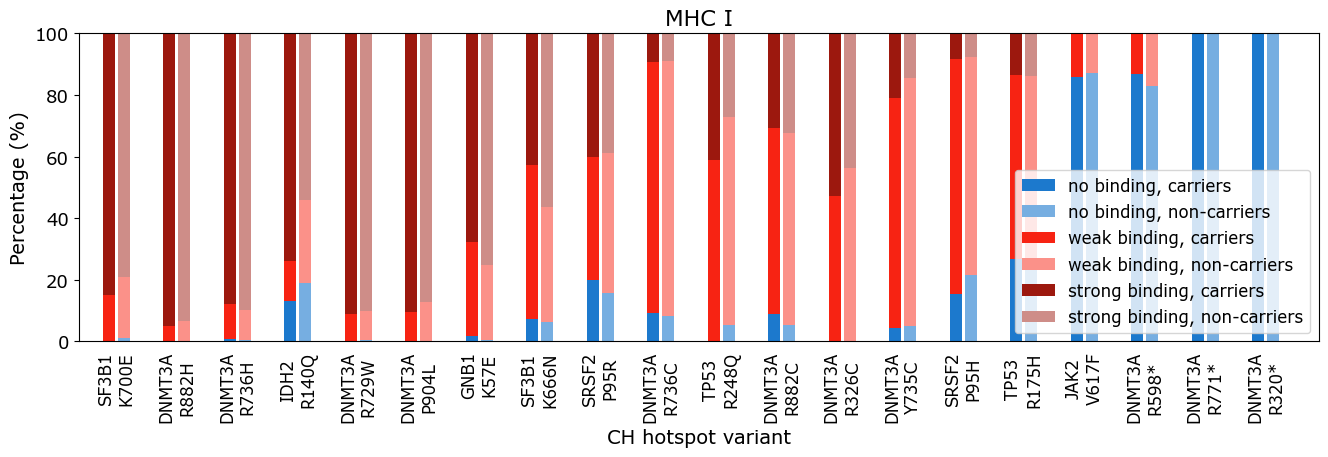

In [79]:

# Prepare
stacked_df_carriers = merged_df_percents_melt[merged_df_percents_melt['group'] == 'carriers'].pivot_table(
    index='gene_var2', columns='binding level', values='value', aggfunc='sum').reset_index()
stacked_df_noncarriers = merged_df_percents_melt[merged_df_percents_melt['group'] == 'noncarriers'].pivot_table(
    index='gene_var2', columns='binding level', values='value', aggfunc='sum').reset_index()
bar_width = 0.4

# Plotting
colors1 = ['#1c79cd', '#f72313', '#9c180e']
colors2 = ['#76aee1', '#fb9189', '#ce8d88']

plt.figure(figsize = (16, 4))

for i, var in enumerate(order_all):

    plt.bar(2*i, stacked_df_carriers[stacked_df_carriers['gene_var2']==var]['no binding'], color=colors1[0], width=bar_width, label='no binding, carriers' if i == 0 else None)
    plt.bar(2*i+0.5, stacked_df_noncarriers[stacked_df_noncarriers['gene_var2']==var]['no binding'], color=colors2[0], width=bar_width, label='no binding, non-carriers' if i == 0 else None)
    
    plt.bar(2*i, stacked_df_carriers[stacked_df_carriers['gene_var2']==var]['weak binding'], color=colors1[1], width=bar_width, label='weak binding, carriers' if i == 0 else None, bottom=stacked_df_carriers[stacked_df_carriers['gene_var2']==var]['no binding'])
    plt.bar(2*i+0.5, stacked_df_noncarriers[stacked_df_noncarriers['gene_var2']==var]['weak binding'], color=colors2[1], width=bar_width, label='weak binding, non-carriers' if i == 0 else None, bottom=stacked_df_noncarriers[stacked_df_noncarriers['gene_var2']==var]['no binding'])
    
    plt.bar(2*i, stacked_df_carriers[stacked_df_carriers['gene_var2']==var]['strong binding'], color=colors1[2], width=bar_width, label='strong binding, carriers' if i == 0 else None, bottom=stacked_df_carriers[stacked_df_carriers['gene_var2']==var]['no binding']+stacked_df_carriers[stacked_df_carriers['gene_var2']==var]['weak binding'])
    plt.bar(2*i+0.5, stacked_df_noncarriers[stacked_df_noncarriers['gene_var2']==var]['strong binding'], color=colors2[2], width=bar_width, label='strong binding, non-carriers' if i == 0 else None, bottom=stacked_df_noncarriers[stacked_df_noncarriers['gene_var2']==var]['no binding']+stacked_df_noncarriers[stacked_df_noncarriers['gene_var2']==var]['weak binding'])

plt.xlim(-1, 2*i+2)
order_all2 = [item for item in order_all for _ in range(2)]
tick_positions = [tick + 0.25 if i % 2 == 0 else tick for i, tick in enumerate(range(len(order_all) * 2))]
tick_labels = [f'{var}' if i % 2 == 0 else '' for i, var in enumerate(order_all2)]
plt.xticks(tick_positions, tick_labels, rotation=90, fontsize = 12)
plt.xlabel(f'CH hotspot variant', fontsize = 14)
plt.ylabel('Percentage (%)', fontsize = 14)
plt.yticks(fontsize = 13)
plt.title('MHC I', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 12)
plt.tick_params(left = True, bottom = False) 
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_method_UKBB_{param}_percentages_by_threshold.pdf', bbox_inches='tight')


In [80]:
# look at VAF scores for cases where you have both binding and no binding 
ch_all_el_rank_log_labels = ch_all_el_rank_log_labels[ch_all_el_rank_log_labels['gene_var2'].isin(order)]

# let's add to everyone group based on score
conditions = [
    (ch_all_el_rank_log_labels['score'] < -1 * np.log10(2)),
    ((ch_all_el_rank_log_labels['score'] >= -1 * np.log10(2)) & (ch_all_el_rank_log_labels['score'] < -1 * np.log10(0.5))),
    (ch_all_el_rank_log_labels['score'] >= -1 * np.log10(0.5))
]
values = ['no binding', 'weak binding', 'strong binding']
ch_all_el_rank_log_labels['binding'] = np.select(conditions, values)
ch_all_el_rank_log_labels['binding']= pd.Categorical(ch_all_el_rank_log_labels['binding'], categories=['no binding', 'weak binding', 'strong binding'], ordered=True)

In [81]:

# add number of cases to the dataframe to be able to include on the x axis 

df_with_nr_carriers = df_compare_to_ref2[['gene_var2', 'CH variant3']]
ch_all_el_rank_log_labels_with_nr = pd.merge(ch_all_el_rank_log_labels, df_with_nr_carriers, on = 'gene_var2')
ch_all_el_rank_log_labels_with_nr = ch_all_el_rank_log_labels_with_nr[~ch_all_el_rank_log_labels_with_nr.duplicated()]

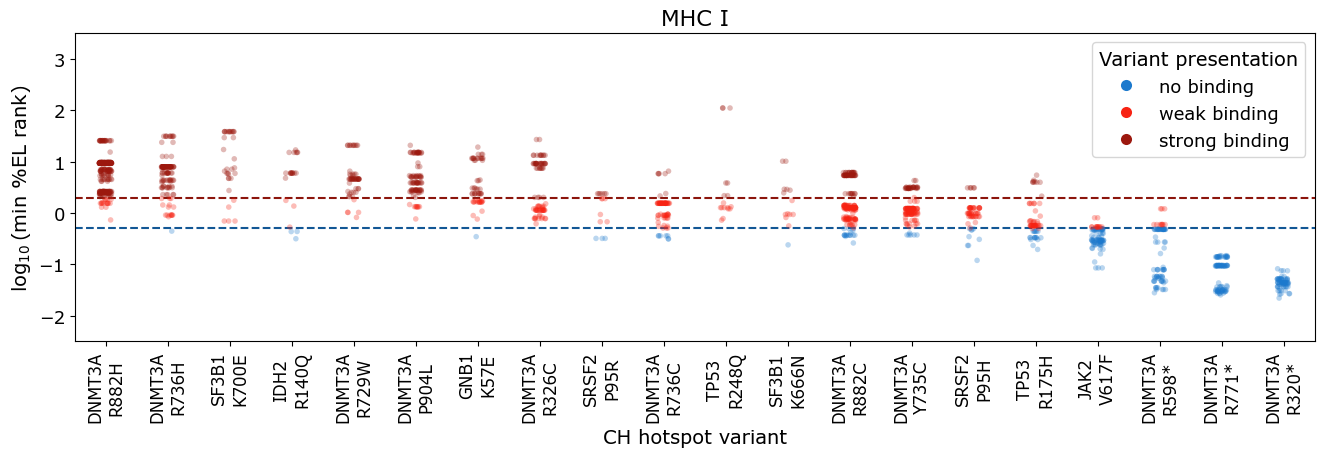

In [82]:
# plot 
# plot carriers vs ALL non-carriers in the dataset examined (aka the ~99k people)
colors1 = ['#1c79cd', '#f72313', '#9c180e']

# plot scores
plt.figure(figsize = (16,4))
sns.stripplot(x = 'gene_var2', y = 'score', hue = 'binding', data = ch_all_el_rank_log_labels_with_nr, palette = colors1, alpha = 0.3, size = 4, order = order)

# add thresholds
plt.axhline(y=-1*np.log10(0.5), color='#8c150c', linestyle='--')
plt.axhline(y=-1*np.log10(2), color='#125795', linestyle='--')

plt.xlabel(f'CH hotspot variant', fontsize = 14)
plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 14)
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 13)
plt.title('MHC I', fontsize = 16)
plt.ylim(-2.5, 3.5)
plt.legend(markerscale = 2, title = 'Variant presentation', loc = 'upper right', fontsize = 13, title_fontsize = 14)
legend = plt.gca().get_legend()
for handle, color in zip(legend.legendHandles, colors):
    handle.set_color(color)
for lh in legend.legendHandles:
    lh.set_alpha(1)
    
plt.tick_params(left = True, bottom = True) 
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_variant_pres_split_by_threshold_v2.pdf', bbox_inches='tight')

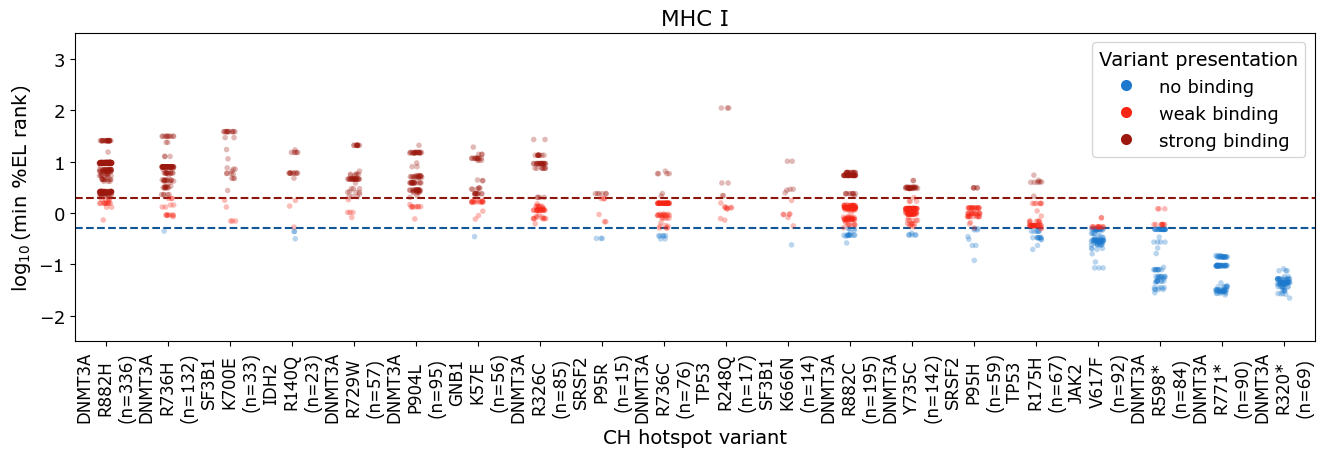

In [83]:
# plot 
# plot carriers vs ALL non-carriers in the dataset examined (aka the ~99k people)
colors1 = ['#1c79cd', '#f72313', '#9c180e']

# plot scores
plt.figure(figsize = (16,4))
sns.stripplot(x = 'CH variant3', y = 'score', hue = 'binding', data = ch_all_el_rank_log_labels_with_nr, palette = colors1, alpha = 0.3, size = 4, order = order_3)

# add thresholds
plt.axhline(y=-1*np.log10(0.5), color='#8c150c', linestyle='--')
plt.axhline(y=-1*np.log10(2), color='#125795', linestyle='--')

plt.xlabel(f'CH hotspot variant', fontsize = 14)
plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 14)
plt.xticks(fontsize = 12, rotation = 90)
plt.yticks(fontsize = 13)
plt.title('MHC I', fontsize = 16)
plt.ylim(-2.5, 3.5)
plt.legend(markerscale = 2, title = 'Variant presentation', loc = 'upper right', fontsize = 13, title_fontsize = 14)
legend = plt.gca().get_legend()
for handle, color in zip(legend.legendHandles, colors):
    handle.set_color(color)
for lh in legend.legendHandles:
    lh.set_alpha(1)
    
plt.tick_params(left = True, bottom = True) 
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_variant_pres_split_by_threshold.pdf', bbox_inches='tight')

In [84]:
# okay now do the cumulative plots for this 

# plots scores for each group on the same plot 
# note: an alternative is to split by thresholds for binding  
# script to do this is included in the complete analysis, but I am not using this way due to issues described there 

# for extreme groups in each split 
dfs_list = ['ch_all_el_rank_log_labels_with_nr']

for name in dfs_list:

    df = globals()[name]

    score = df.score_type[0]
    score_title = score.replace('_', ' ')
    
    df['VAF_percent'] = df['VAF'] * 100
    colors = colors1

    variants = df['gene_var'].unique()

    # plot for each variant separately 
    for var in variants: 

        data = df[df['gene_var'] == var]

        # don't plot if there are less than 5 observations in either category 
        if data[data['binding']=='no binding'].shape[0] < 5:
            data = data[data['binding']!='no binding']
        elif data[data['binding']=='weak binding'].shape[0] < 5 :
            data = data[data['binding']!='weak binding']
        elif data[data['binding']=='strong binding'].shape[0] < 5:
            data = data[data['binding']!='strong binding']
        
        else:
            data = data.sort_values(by='VAF')
            N = data.shape[0]
            # add number of people in each category 
            data['group_size'] = data.groupby('binding')['binding'].transform('count')
            data['index_vaf_group'] = data.groupby('binding')['VAF'].rank(ascending=False) # index by VAF
            data['fraction_index_presenter_group'] = data['index_vaf_group'] / data['group_size']
        
            plot_cumulative(data, 'VAF_percent', 'fraction_index_presenter_group', 'binding', colors, 'VAF (%)', f'Cumulative probability', var, score, score_title, f'{nr_groups}_groups_thesholds_allon1')


In [91]:
# okay now binding / no binding
# look at VAF scores for cases where you have both binding and no binding 
ch_all_el_rank_log_labels = ch_all_el_rank_log_labels[ch_all_el_rank_log_labels['gene_var2'].isin(order)]

# let's add to everyone group based on score
conditions = [
    (ch_all_el_rank_log_labels_with_nr['score'] < -1 * np.log10(2)),
    (ch_all_el_rank_log_labels_with_nr['score'] >= -1 * np.log10(2))
]
values = ['no binding', 'binding']

ch_all_el_rank_log_labels_with_nr['binding_any'] = np.select(conditions, values)
ch_all_el_rank_log_labels_with_nr['binding_any']= pd.Categorical(ch_all_el_rank_log_labels_with_nr['binding_any'], categories=['no binding', 'binding'], ordered=True)

In [94]:
# okay now repeat this but binding / no binding 

# define function to plot cumulative probability
def plot_cumulative_mhci(data, x, y, hue, colors, xlabel, ylabel, var, score, score_title, name):

    var_name = var.split('_')[0:2]
    var_name = ' '.join(var_name)

    nr_cases = data.shape[0]

    plt.figure(figsize=(4,4)) 
    sns.lineplot(x=x, y=y, data=data, hue=hue, palette=colors, legend = True)
    sns.scatterplot(x=x, y=y, data=data, hue=hue, palette=colors, legend = False, alpha = 0.3, linewidth=0)

    # specify title and axes labels 
    plt.title(f'{var_name} (n={nr_cases})', fontsize = 12)
    plt.xlabel(xlabel, fontsize = 10)
    plt.ylabel(ylabel, fontsize = 10)

    # convert both axes to log scale 
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')

    # adjust legend 
    legend = plt.legend()
    legend.prop.set_size(10) 
    plt.legend(title = 'MHC I presentation', loc = 'lower left', fontsize = 10, title_fontsize = 11)

    # specify ticks on the x axis 
    x_ticks = [1, 3, 10, 30]
    plt.xticks(x_ticks, x_ticks, fontsize = 9)

    y_ticks = [1, 0.3, 0.1, 0.03]
    plt.yticks(y_ticks, y_ticks, fontsize = 9)
    
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_UKBB_VAF_{hue}_{name}_{score}_{var}_threshold_mhci.pdf', bbox_inches='tight')
    plt.close()

In [95]:
# okay now do the cumulative plots for this 

# plots scores for each group on the same plot 
# note: an alternative is to split by thresholds for binding  
# script to do this is included in the complete analysis, but I am not using this way due to issues described there 

# for extreme groups in each split 
dfs_list = ['ch_all_el_rank_log_labels_with_nr']

for name in dfs_list:

    df = globals()[name]

    score = df.score_type[0]
    score_title = score.replace('_', ' ')
    
    df['VAF_percent'] = df['VAF'] * 100
    colors = colors1

    variants = df['gene_var'].unique()

    # plot for each variant separately 
    for var in variants: 

        data = df[df['gene_var'] == var]        
        data = data.sort_values(by='VAF')
        N = data.shape[0]
        # add number of people in each category 
        data['group_size'] = data.groupby('binding_any')['binding_any'].transform('count')
        data['index_vaf_group'] = data.groupby('binding_any')['VAF'].rank(ascending=False) # index by VAF
        data['fraction_index_presenter_group'] = data['index_vaf_group'] / data['group_size']
    
        plot_cumulative_mhci(data, 'VAF_percent', 'fraction_index_presenter_group', 'binding_any', colors, 'VAF (%)', f'Cumulative probability', var, score, score_title, f'{nr_groups}_groups_thesholds_allon1')


# Test 5: Present vs absent mutations

In [169]:

# PLOT2: Is the score of the variant in people who carry it different from scores of other variants?
# for this plot, order the df by score for present variants

def plot_scores_variant_carried_vs_other(df):

    score = df.score_type[0]
    colors = ['#F76655', '#981F11'] # I want similar colors but I guess not identical ones?
    
    df_sort = df.sort_values(by='median_score', ascending = False)
    order = df_sort.gene_var2.unique()

    # plot 1: boxplot
    plt.figure(figsize = (16,4))
    sns.boxplot(x="gene_var2", y="value", hue = 'is_variant_present', data=df, showfliers = False, order = order, palette = colors)
    plt.xlabel(f'CH carrier genotype', fontsize = 14)
    plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 14)
    plt.xticks(fontsize = 12, rotation = 90)
    plt.yticks(fontsize = 13)
    plt.title('MHC I', fontsize = 16)
    plt.ylim(-2.5, 3.5)
    plt.legend(title='CH variant', loc = 'upper right', fontsize = 10, title_fontsize = 11)
    legend = plt.gca().get_legend()
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_UKBB_{score}_boxplot_correct_genotype.pdf', bbox_inches='tight')

    # plot 2: stripplot (side by side, I scrapped overlay because it looks terrible)
    plt.figure(figsize = (16,4))
    p = sns.stripplot(x="gene_var2", y="value", hue = 'is_variant_present', data=df, dodge=True, size = 3, order = order, palette = colors, alpha = 0.3)
    plt.xlabel(f'CH carrier genotype', fontsize = 14)
    plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 14)
    plt.xticks(fontsize = 12, rotation = 90)
    plt.yticks(fontsize = 13)
    plt.title('MHC I', fontsize = 16)
    plt.ylim(-2.5, 3.5)
    plt.legend(title='CH variant', labels=['Variant carried', 'Other variants'], markerscale=2, loc = 'upper right', fontsize = 10, title_fontsize = 11)
    legend = plt.gca().get_legend()
    for handle, color in zip(legend.legendHandles, colors):
        handle.set_color(color)
    for lh in legend.legendHandles:
        lh.set_alpha(1)

    for i, category in enumerate(order):

        median_present = df[(df['gene_var2'] == category) & (df['is_variant_present'] == True)]['value'].median()
        median_absent = df[(df['gene_var2'] == category) & (df['is_variant_present'] == False)]['value'].median()
        plt.text(i-0.01, median_present, '—', ha='right', va='center', fontsize=17, fontweight='bold', color = '#F76655')
        plt.text(i+0.01, median_absent, '—', ha='left', va='center', fontsize=17, fontweight='bold', color = '#981F11')
        
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_UKBB_{score}_jitter_correct_genotype_sidebyside.pdf', bbox_inches='tight')

In [170]:

# add column to plot 

ch_all_el_rank_log_melted_sort['gene_var2'] = ch_all_el_rank_log_melted_sort['gene_var'].str.replace('_', '\n')
scores = [f'score_{var}' for var in variants_to_examine]

ch_all_el_rank_log_melted_sort = ch_all_el_rank_log_melted_sort[ch_all_el_rank_log_melted_sort['gene_var'].isin(variants_to_examine)]
ch_all_el_rank_log_melted_sort = ch_all_el_rank_log_melted_sort[ch_all_el_rank_log_melted_sort['variable'].isin(scores)]

ch_all_el_rank_log_melted_sort['is_variant_present3'] = ch_all_el_rank_log_melted_sort['is_variant_present'].map({True:'Variant carried', False:'Other variants'})

ch_all_el_rank_log_melted_sort_ri = ch_all_el_rank_log_melted_sort.reset_index()

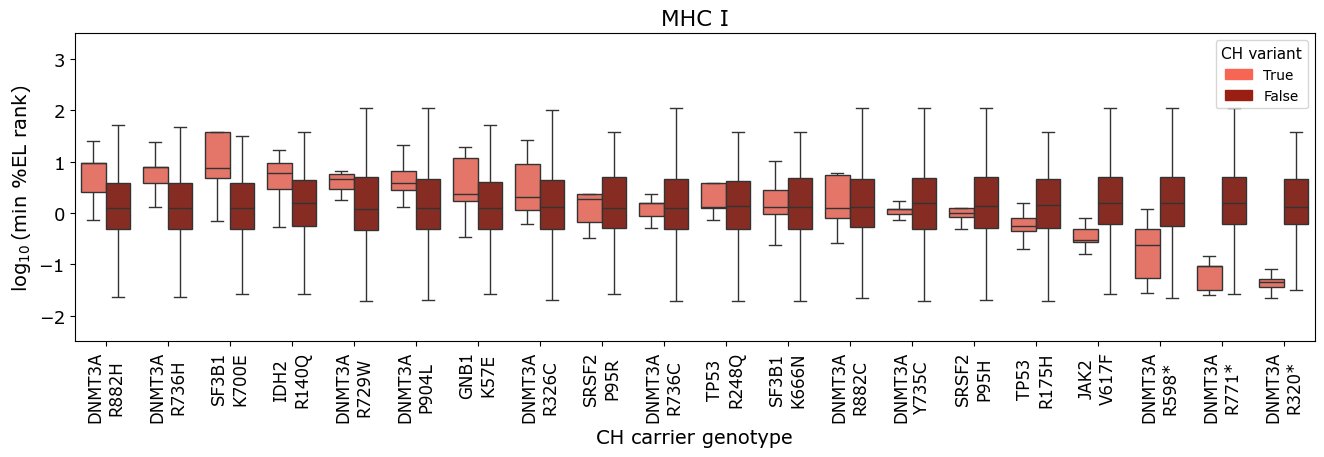

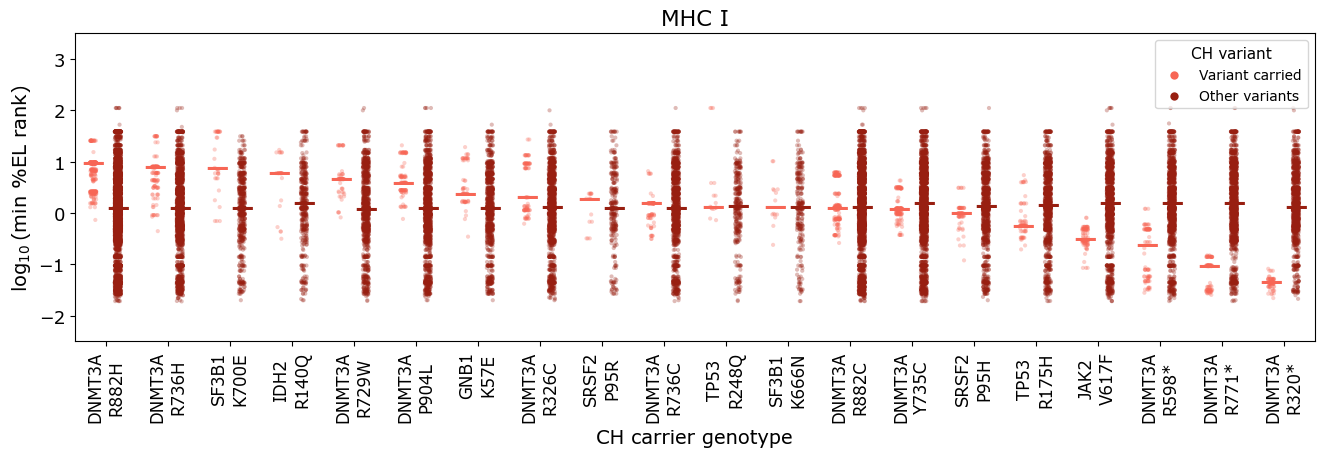

In [171]:
# create plots 
plot_scores_variant_carried_vs_other(ch_all_el_rank_log_melted_sort_ri)

In [172]:
df_xaxis = df_compare_to_ref2[['CH variant3', 'gene_var2']]
df_xaxis = df_xaxis[df_xaxis['gene_var2'] != 'reference set']

ch_all_el_rank_log_melted_sort_ri = pd.merge(ch_all_el_rank_log_melted_sort_ri, df_xaxis, on = 'gene_var2')
ch_all_el_rank_log_melted_sort_ri = ch_all_el_rank_log_melted_sort_ri[~ch_all_el_rank_log_melted_sort_ri.duplicated()]

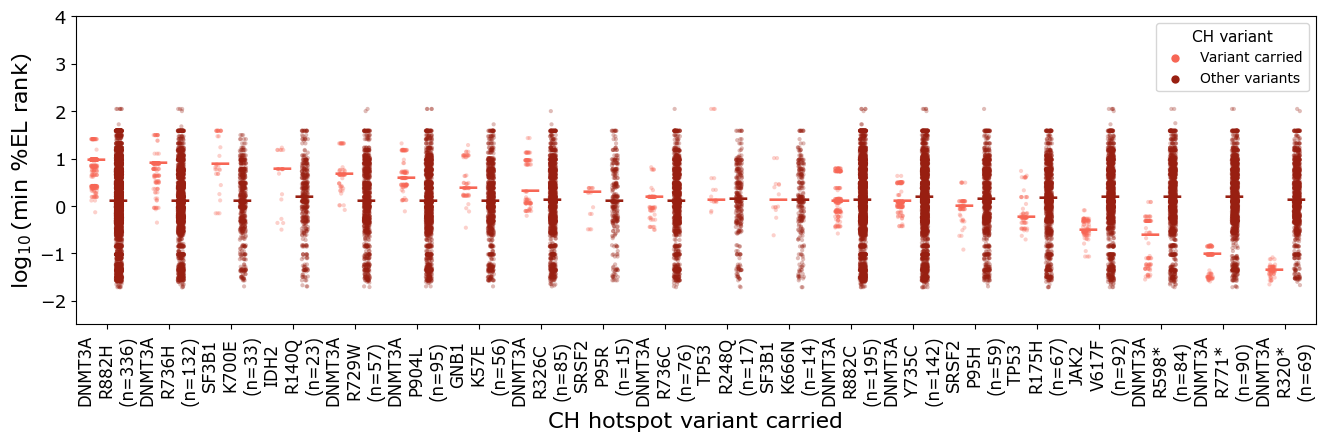

In [173]:
# add number of carriers to x axis
colors = ['#F76655', '#981F11']

plt.figure(figsize = (16,4))

p = sns.stripplot(x="CH variant3", y="value", hue = 'is_variant_present', data=ch_all_el_rank_log_melted_sort_ri, dodge=True, size = 3, order = order_3, palette = colors, alpha = 0.3)
plt.ylim(-2.5, 4)
plt.xlabel('CH hotspot variant carried', fontsize = 16)
plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 16)
plt.xticks(rotation = 90, fontsize = 12)
plt.yticks(fontsize = 13)
plt.legend(title='CH variant', labels=['Variant carried', 'Other variants'], markerscale=2, loc = 'upper right', fontsize = 10, title_fontsize = 11)
legend = plt.gca().get_legend()
for handle, color in zip(legend.legendHandles, colors):
    handle.set_color(color)
for lh in legend.legendHandles:
    lh.set_alpha(1)

for i, category in enumerate(order_3):

    median_present = ch_all_el_rank_log_melted_sort_ri[(ch_all_el_rank_log_melted_sort_ri['CH variant3'] == category) & (ch_all_el_rank_log_melted_sort_ri['is_variant_present'] == True)]['value'].median()
    median_absent = ch_all_el_rank_log_melted_sort_ri[(ch_all_el_rank_log_melted_sort_ri['CH variant3'] == category) & (ch_all_el_rank_log_melted_sort_ri['is_variant_present'] == False)]['value'].median()
    plt.text(i-0.01, median_present, '—', ha='right', va='center', fontsize=15, fontweight='bold', color = '#F76655')
    plt.text(i+0.01, median_absent, '—', ha='left', va='center', fontsize=15, fontweight='bold', color = '#981F11')
    
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_UKBB_{score}_jitter_correct_genotype_sidebyside_with_nrs.pdf', bbox_inches='tight')

In [174]:

# plot aggregate

def plot_observed_vs_unobserved(data, x, y, xlabel, name, var, score, score_title):
    
    colors = ['#F76655', '#981F11']

    # BOXPLOT
    plt.figure(figsize=(4,4)) 
    p = sns.boxplot(x=x, y=y, data=data, hue=x, palette=colors, legend=False, showfliers = False)
    plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 13)
    plt.xlabel(None)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(-2.5, 3.5)
    
    # Mann-Whitney test (two groups, non-parametric)
    statistic, p_value = mannwhitneyu(data[data[x] == 'Variant carried'][y], 
        data[data[x] == 'Other variants'][y])

    p_value_mann_u = f'< 0.0001' if p_value < 0.0001 else f'{p_value:.4f}'
    p_value_mann_u = f'Mann Whitney\n p value: {p_value_mann_u}'
    plt.annotate(p_value_mann_u, xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=10)
    
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_UKBB_{score}_mutation_observed_vs_not_{name}_boxplot.pdf', bbox_inches='tight')

    # JITTER
    plt.figure(figsize=(4,4)) 
    p = sns.stripplot(x=x, y=y, data=data, hue=x, palette=colors, legend=False, dodge = False, size = 4, alpha = 0.3)
    plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 13)
    plt.xlabel(None)
    plt.ylim(-2.5, 3.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Mann-Whitney test (two groups, non-parametric)
    statistic, p_value = mannwhitneyu(data[data[x] == 'Variant carried'][y], 
        data[data[x] == 'Other variants'][y])
    p_value_mann_u = f'< 0.0001' if p_value < 0.00005 else f'{p_value:.4f}'
    p_value_mann_u = f'Mann Whitney\n p value: {p_value_mann_u}'
    plt.annotate(p_value_mann_u, xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=10)
    
    # add annotation to indicate median
    median_present = data[data[x] == 'Variant carried'][y].median()
    median_absent = data[data[x] == 'Other variants'][y].median()
    plt.text(0, median_present, '—', ha='center', va='center', fontsize=45, fontweight='bold', color = '#F76655')
    plt.text(1, median_absent, '—', ha='center', va='center', fontsize=45, fontweight='bold', color = '#981F11')
    
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures_v2/figure2/{timestr}/{timestr}_UKBB_{score}_mutation_observed_vs_not_{name}_jitter.pdf', bbox_inches='tight')


# define function to plot across dataframes 
def observed_unobserved(df):

    score = df.score_type[0]
    score_title = score.replace('_', ' ')

    variants = []

    for var in variants:
        
        var_name = var.split('_')[0:2]
        var_name = ' '.join(var_name)

        data = df[df['variable'] == f'score_{var}'] # select entries with the variant 
        plot_observed_vs_unobserved(data, 'is_variant_present3', 'value', 'Mutation observed', 'score', var, var_name, score, score_title)

    # plot all variants together
    plot_observed_vs_unobserved(df, 'is_variant_present3', 'value', 'Mutation observed', 'all_22variants', 'All CH cases', score, score_title)
    

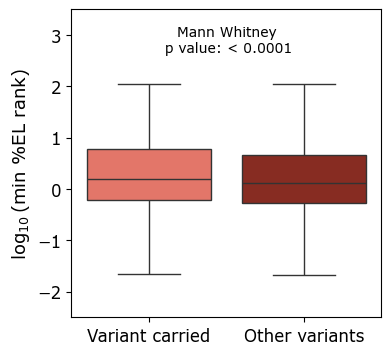

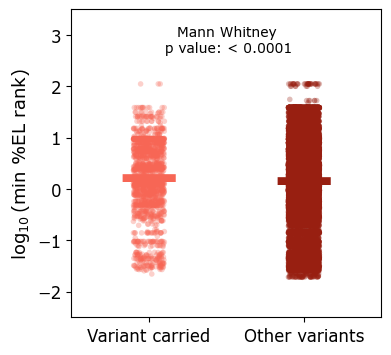

: 

In [175]:

# plot aggregate
observed_unobserved(ch_all_el_rank_log_melted_sort_ri)
# nb top 10 variants - 908 cases, bottom 10 variants - 812 cases that's why it's a bit higher in the variant carried bit 
    